Test Script

In [9]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


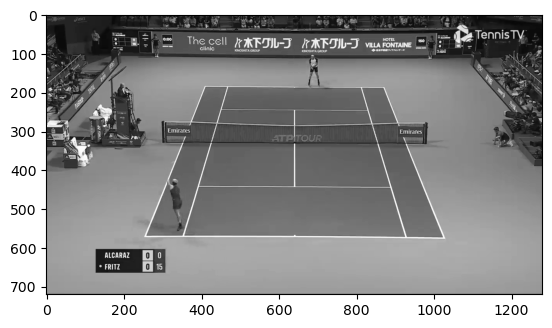

In [10]:
img = cv2.imread('data/sample_frames/output.png', cv2.IMREAD_COLOR)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cmap='gray')
plt.show()


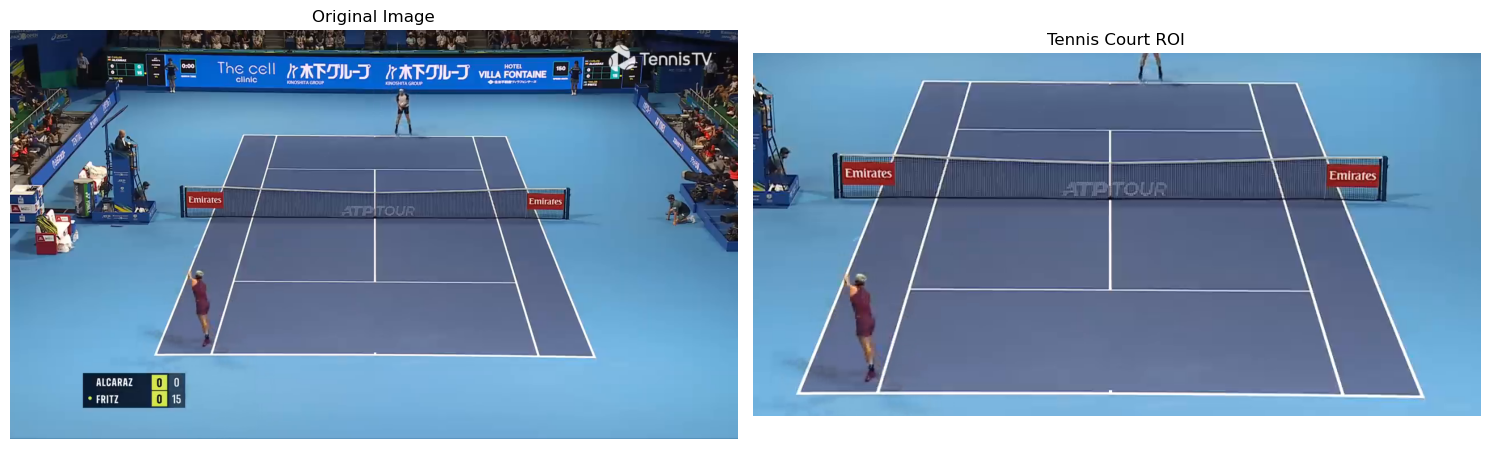

Original image shape: (720, 1280, 3)
Court ROI shape: (450, 900, 3)


In [11]:
# Crop the image to focus on the tennis court region
# x: 200-1100, y: 100-600 to avoid crowd interference
court_roi = img[150:600, 200:1100]

# Display original and cropped images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(cv2.cvtColor(court_roi, cv2.COLOR_BGR2RGB))
ax2.set_title('Tennis Court ROI')
ax2.axis('off')

plt.tight_layout()
plt.show()

print(f"Original image shape: {img.shape}")
print(f"Court ROI shape: {court_roi.shape}")

# Method 1: Edge Detection with Canny
Let's start with Canny edge detection to find all edges in the court region.

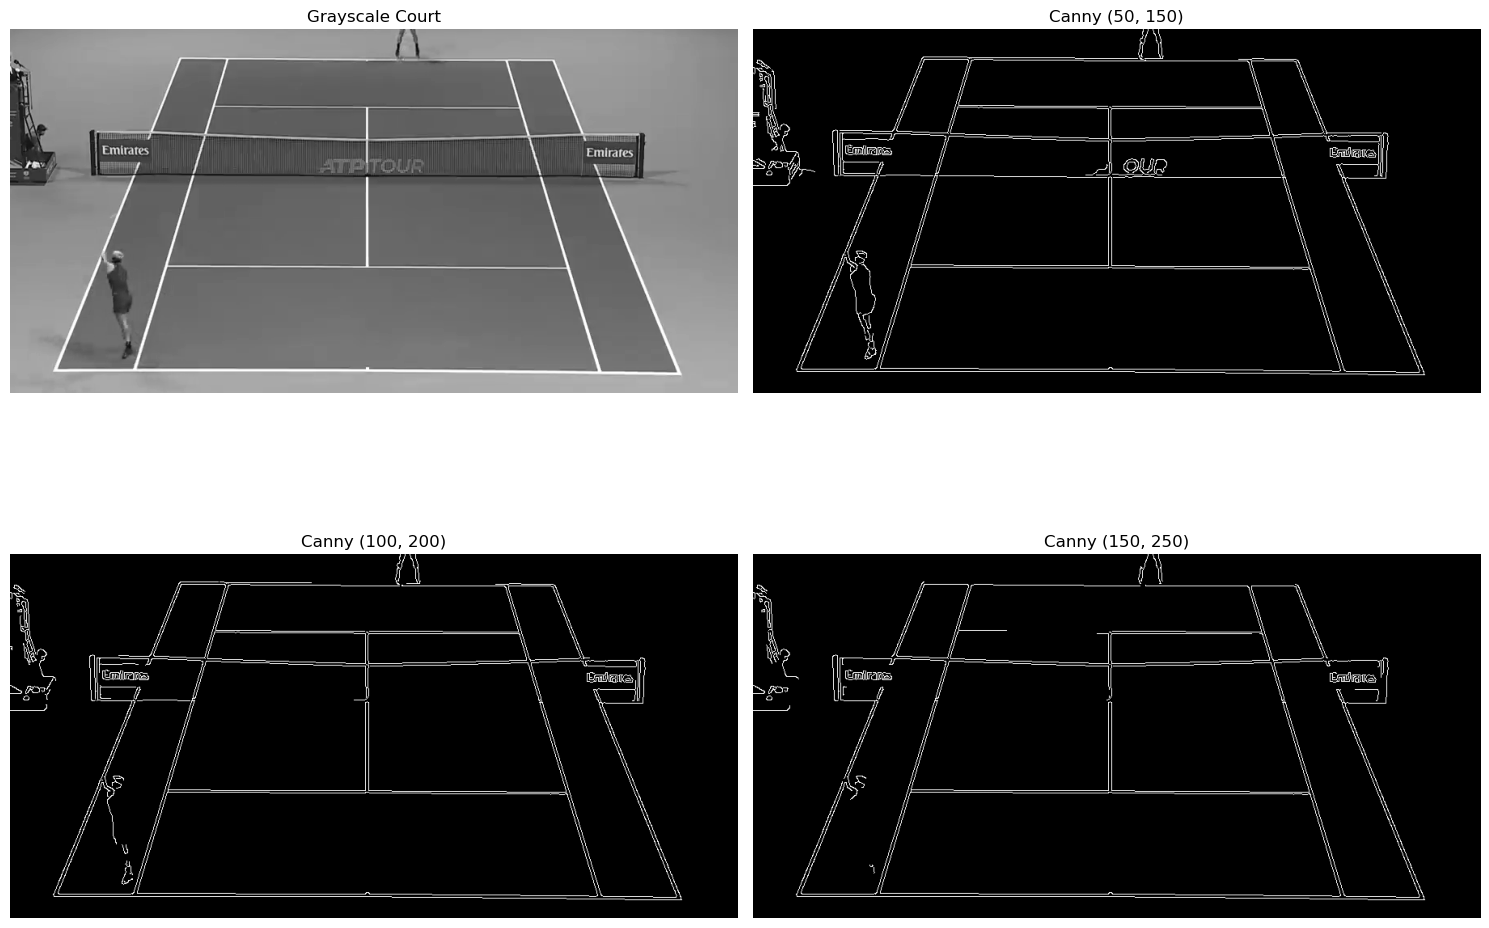

In [12]:
# Convert to grayscale
gray = cv2.cvtColor(court_roi, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply Canny edge detection with different thresholds
edges_low = cv2.Canny(blurred, 50, 150)
edges_medium = cv2.Canny(blurred, 100, 200)
edges_high = cv2.Canny(blurred, 150, 250)

# Display results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].imshow(gray, cmap='gray')
axes[0, 0].set_title('Grayscale Court')
axes[0, 0].axis('off')

axes[0, 1].imshow(edges_low, cmap='gray')
axes[0, 1].set_title('Canny (50, 150)')
axes[0, 1].axis('off')

axes[1, 0].imshow(edges_medium, cmap='gray')
axes[1, 0].set_title('Canny (100, 200)')
axes[1, 0].axis('off')

axes[1, 1].imshow(edges_high, cmap='gray')
axes[1, 1].set_title('Canny (150, 250)')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# Method 2: Hough Line Transform
Now let's use Hough Line Transform to detect straight lines in the court.

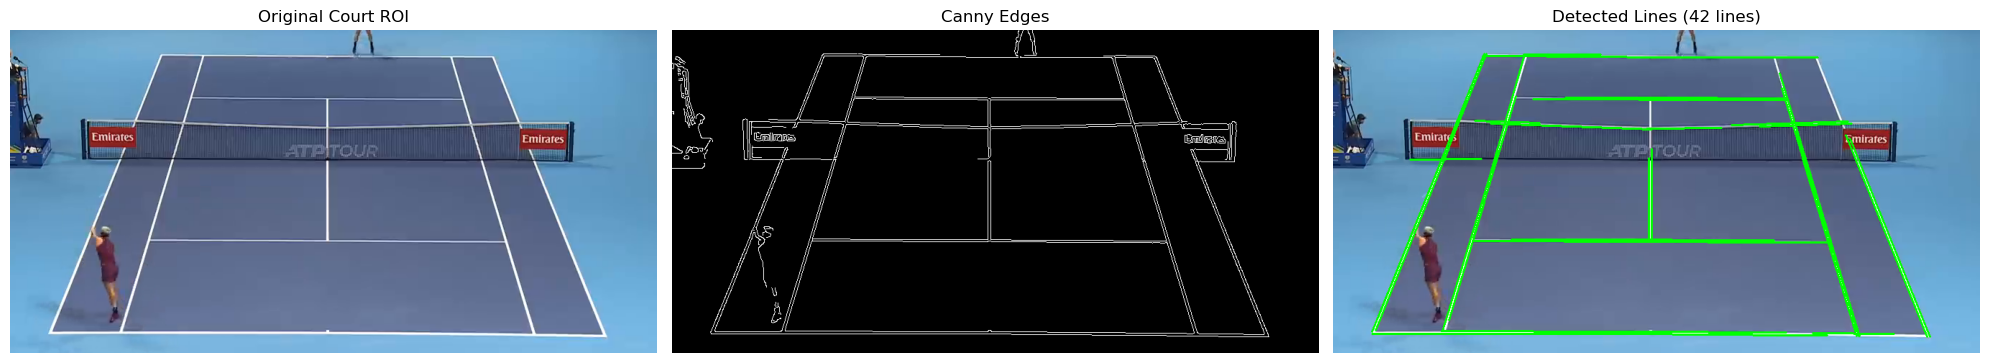

Number of lines detected: 42


In [13]:
# Use the medium Canny result for line detection
edges = edges_medium.copy()

# Apply Hough Line Transform
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=80, minLineLength=50, maxLineGap=10)

# Create a copy of the original court ROI to draw lines on
court_with_lines = court_roi.copy()

# Draw detected lines
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(court_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display results
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

axes[0].imshow(cv2.cvtColor(court_roi, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Court ROI')
axes[0].axis('off')

axes[1].imshow(edges, cmap='gray')
axes[1].set_title('Canny Edges')
axes[1].axis('off')

axes[2].imshow(cv2.cvtColor(court_with_lines, cv2.COLOR_BGR2RGB))
axes[2].set_title(f'Detected Lines ({len(lines) if lines is not None else 0} lines)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Number of lines detected: {len(lines) if lines is not None else 0}")

# Method 3: Color-based Line Detection
Tennis court lines are typically white, so let's try color-based detection.

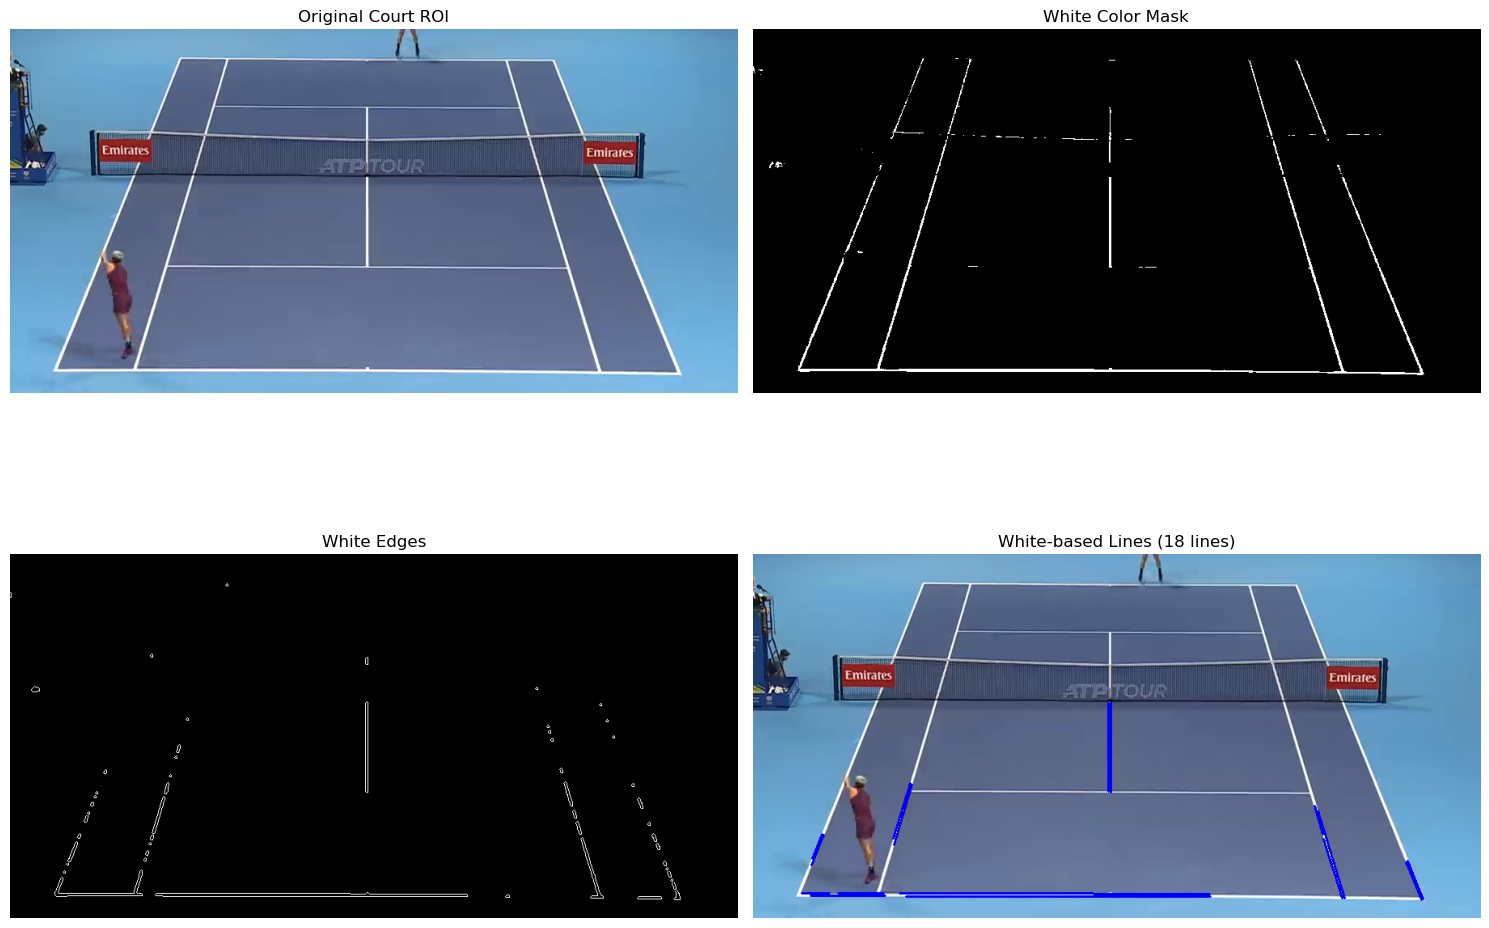

Number of white-based lines detected: 18


In [14]:
# Convert to HSV for better color detection
hsv = cv2.cvtColor(court_roi, cv2.COLOR_BGR2HSV)

# Define range for white color (tennis court lines)
# HSV ranges for white: H: 0-180, S: 0-30, V: 200-255
lower_white = np.array([0, 0, 200])
upper_white = np.array([180, 30, 255])

# Create mask for white regions
white_mask = cv2.inRange(hsv, lower_white, upper_white)

# Apply morphological operations to clean up the mask
kernel = np.ones((3, 3), np.uint8)
white_mask_cleaned = cv2.morphologyEx(white_mask, cv2.MORPH_CLOSE, kernel)
white_mask_cleaned = cv2.morphologyEx(white_mask_cleaned, cv2.MORPH_OPEN, kernel)

# Apply Canny edge detection on the white mask
white_edges = cv2.Canny(white_mask_cleaned, 50, 150)

# Detect lines from white edges
white_lines = cv2.HoughLinesP(white_edges, 1, np.pi/180, threshold=30, minLineLength=30, maxLineGap=5)

# Draw white-based lines
court_white_lines = court_roi.copy()
if white_lines is not None:
    for line in white_lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(court_white_lines, (x1, y1), (x2, y2), (255, 0, 0), 2)

# Display results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].imshow(cv2.cvtColor(court_roi, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('Original Court ROI')
axes[0, 0].axis('off')

axes[0, 1].imshow(white_mask, cmap='gray')
axes[0, 1].set_title('White Color Mask')
axes[0, 1].axis('off')

axes[1, 0].imshow(white_edges, cmap='gray')
axes[1, 0].set_title('White Edges')
axes[1, 0].axis('off')

axes[1, 1].imshow(cv2.cvtColor(court_white_lines, cv2.COLOR_BGR2RGB))
axes[1, 1].set_title(f'White-based Lines ({len(white_lines) if white_lines is not None else 0} lines)')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print(f"Number of white-based lines detected: {len(white_lines) if white_lines is not None else 0}")

# Method 4: Contour Detection
Let's try finding contours to detect the court perimeter.

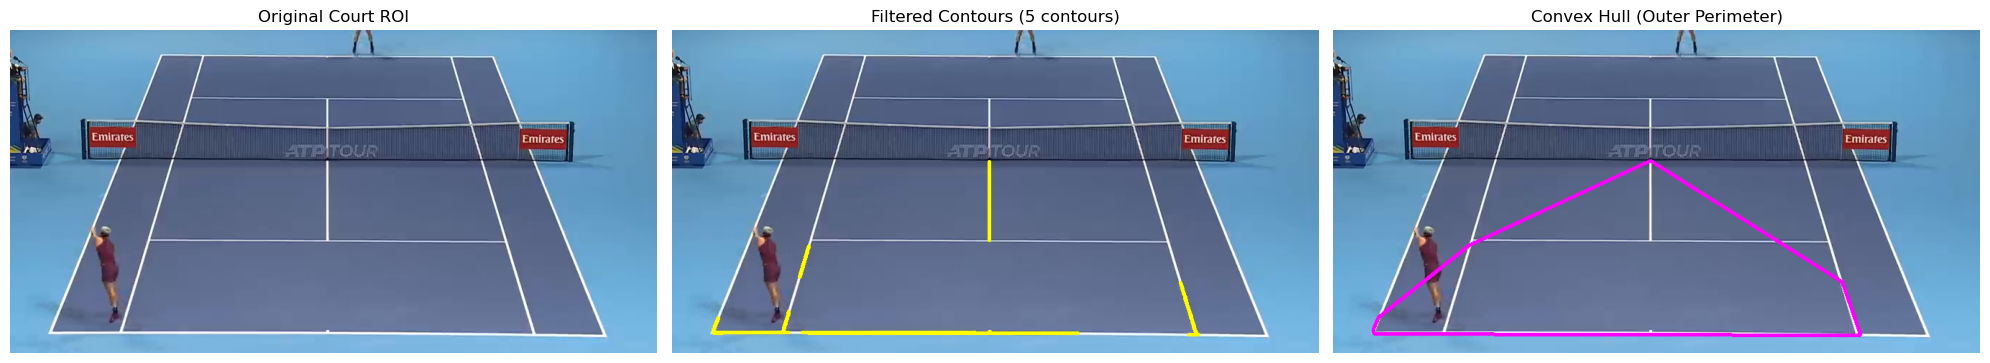

Total contours found: 53
Filtered contours: 5
Convex hull points: 12


In [15]:
# Find contours from the white mask
contours, hierarchy = cv2.findContours(white_mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours by area and aspect ratio
filtered_contours = []
for contour in contours:
    area = cv2.contourArea(contour)
    if area > 100:  # Filter small contours
        # Get bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h
        
        # Keep contours that might represent lines (high aspect ratio or significant area)
        if aspect_ratio > 2 or aspect_ratio < 0.5 or area > 500:
            filtered_contours.append(contour)

# Draw contours
court_contours = court_roi.copy()
cv2.drawContours(court_contours, filtered_contours, -1, (0, 255, 255), 2)

# Also try to find the outer court perimeter using convex hull
if filtered_contours:
    # Combine all contour points
    all_points = np.vstack(filtered_contours)
    # Find convex hull (outer perimeter)
    hull = cv2.convexHull(all_points)
    
    court_hull = court_roi.copy()
    cv2.drawContours(court_hull, [hull], -1, (255, 0, 255), 3)
else:
    court_hull = court_roi.copy()
    hull = None

# Display results
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

axes[0].imshow(cv2.cvtColor(court_roi, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Court ROI')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(court_contours, cv2.COLOR_BGR2RGB))
axes[1].set_title(f'Filtered Contours ({len(filtered_contours)} contours)')
axes[1].axis('off')

axes[2].imshow(cv2.cvtColor(court_hull, cv2.COLOR_BGR2RGB))
axes[2].set_title('Convex Hull (Outer Perimeter)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Total contours found: {len(contours)}")
print(f"Filtered contours: {len(filtered_contours)}")
print(f"Convex hull points: {len(hull) if hull is not None else 0}")

# Method 5: Advanced Preprocessing + Line Filtering
Let's combine multiple techniques with better preprocessing and line filtering.

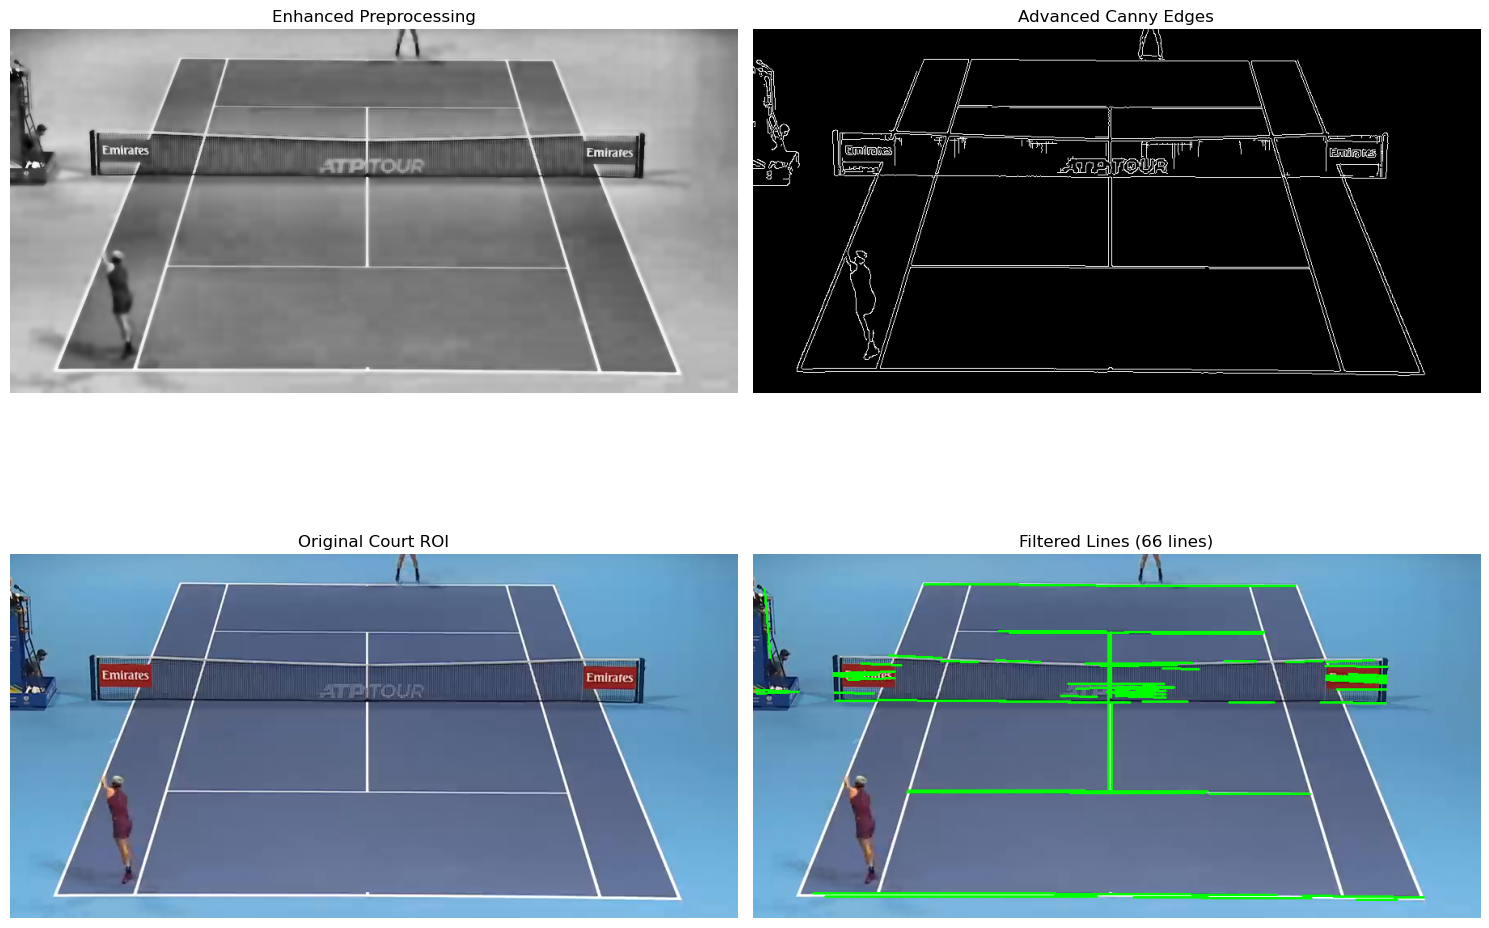

Lines before filtering: 84
Lines after orientation filtering: 66


In [16]:
# Advanced preprocessing
def preprocess_court_image(image):
    # Convert to LAB color space for better contrast
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_channel = lab[:, :, 0]
    
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(l_channel)
    
    # Apply bilateral filter to reduce noise while preserving edges
    filtered = cv2.bilateralFilter(enhanced, 9, 75, 75)
    
    return filtered

def filter_lines_by_orientation(lines, angle_threshold=15):
    """Filter lines to keep only horizontal and vertical lines"""
    if lines is None:
        return None
    
    filtered_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        
        # Calculate angle
        if x2 - x1 == 0:  # Vertical line
            angle = 90
        else:
            angle = np.abs(np.arctan((y2 - y1) / (x2 - x1)) * 180 / np.pi)
        
        # Keep lines that are close to horizontal (0°) or vertical (90°)
        if angle <= angle_threshold or angle >= (90 - angle_threshold):
            filtered_lines.append(line)
    
    return np.array(filtered_lines) if filtered_lines else None

# Apply advanced preprocessing
preprocessed = preprocess_court_image(court_roi)

# Apply Canny edge detection
edges_advanced = cv2.Canny(preprocessed, 50, 150, apertureSize=3)

# Detect lines
lines_advanced = cv2.HoughLinesP(edges_advanced, 1, np.pi/180, 
                                threshold=60, minLineLength=40, maxLineGap=8)

# Filter lines by orientation
filtered_lines = filter_lines_by_orientation(lines_advanced, angle_threshold=10)

# Draw filtered lines
court_advanced = court_roi.copy()
if filtered_lines is not None:
    for line in filtered_lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(court_advanced, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].imshow(preprocessed, cmap='gray')
axes[0, 0].set_title('Enhanced Preprocessing')
axes[0, 0].axis('off')

axes[0, 1].imshow(edges_advanced, cmap='gray')
axes[0, 1].set_title('Advanced Canny Edges')
axes[0, 1].axis('off')

axes[1, 0].imshow(cv2.cvtColor(court_roi, cv2.COLOR_BGR2RGB))
axes[1, 0].set_title('Original Court ROI')
axes[1, 0].axis('off')

axes[1, 1].imshow(cv2.cvtColor(court_advanced, cv2.COLOR_BGR2RGB))
axes[1, 1].set_title(f'Filtered Lines ({len(filtered_lines) if filtered_lines is not None else 0} lines)')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print(f"Lines before filtering: {len(lines_advanced) if lines_advanced is not None else 0}")
print(f"Lines after orientation filtering: {len(filtered_lines) if filtered_lines is not None else 0}")

# Comparison and Summary
Let's compare all methods and analyze which one works best for tennis court line detection.

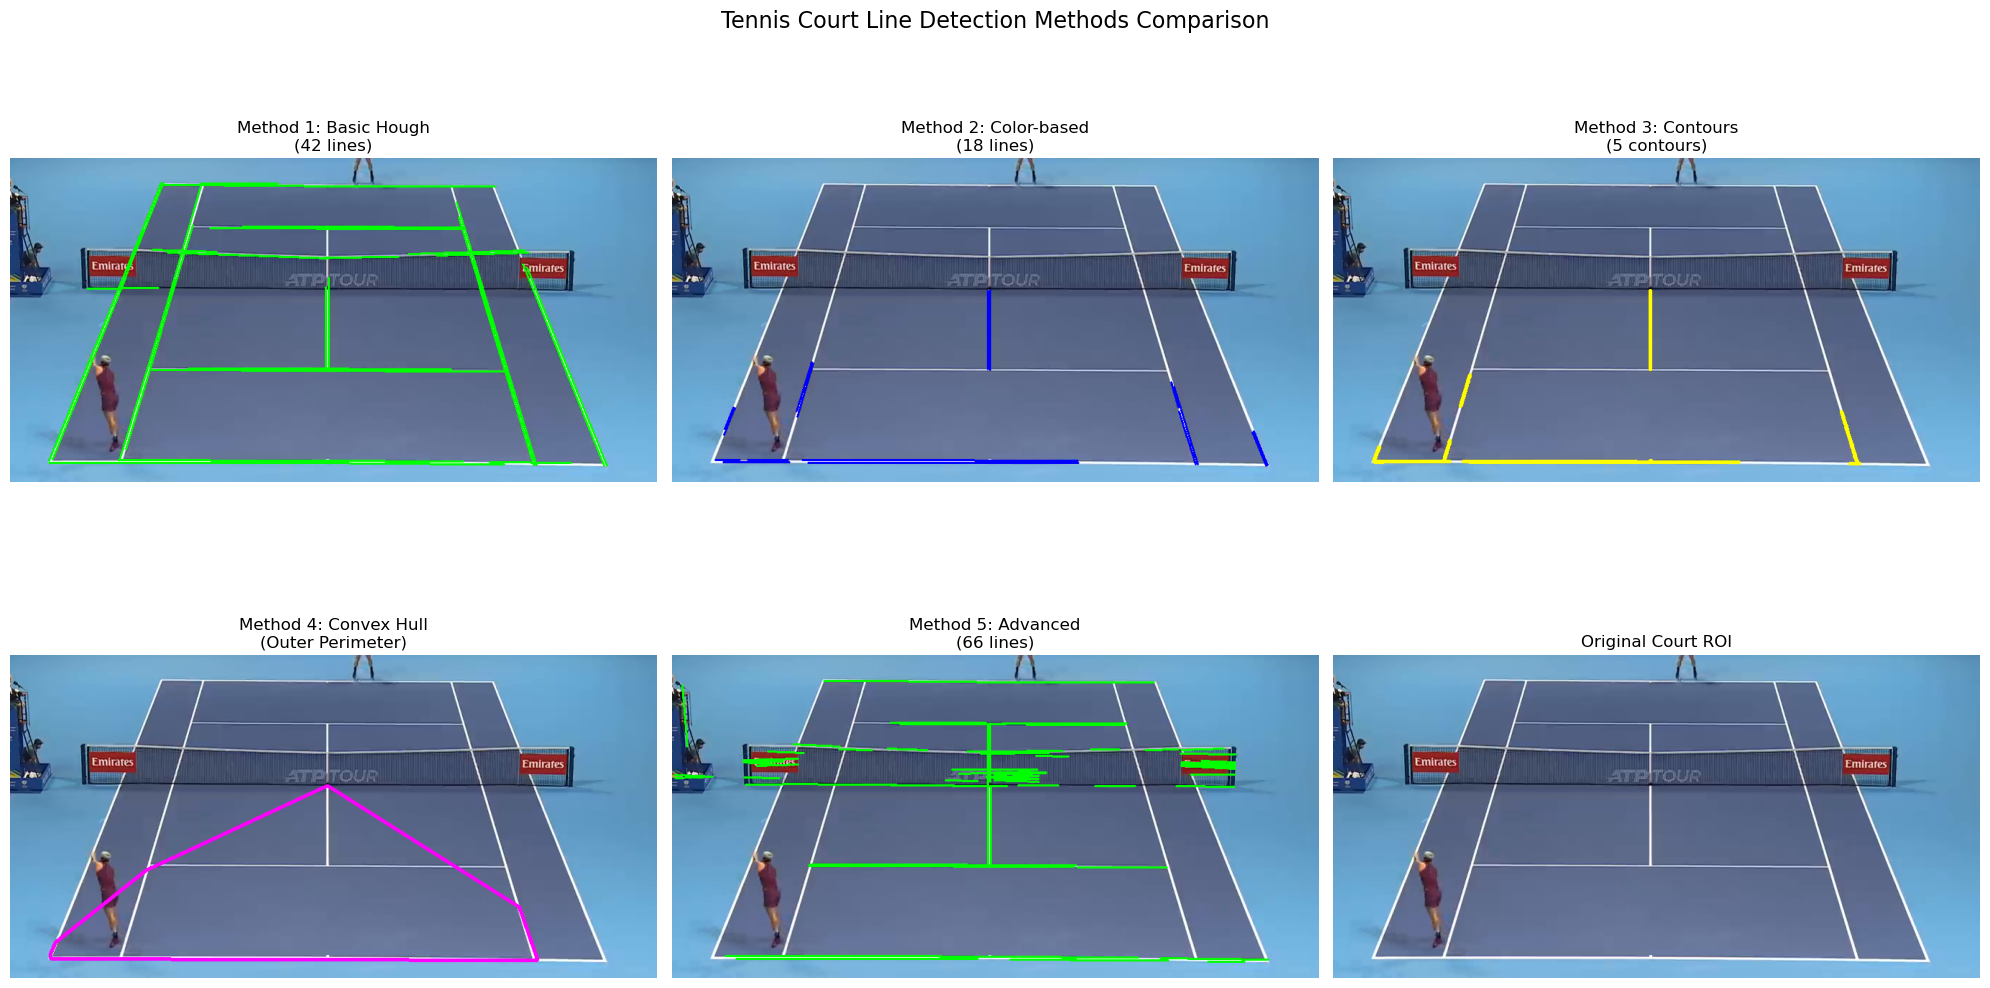

=== SUMMARY ===
Method 1 (Basic Hough): 42 lines detected
Method 2 (Color-based): 18 lines detected
Method 3 (Contours): 5 contours detected
Method 4 (Convex Hull): Outer perimeter detection
Method 5 (Advanced): 66 filtered lines detected

Recommendations:
- Method 2 (Color-based) seems most promising for tennis court lines
- Method 5 (Advanced) provides cleaner results with orientation filtering
- Combine methods 2 and 5 for best results
- Method 4 (Convex Hull) is good for outer court boundary


In [17]:
# Create a comprehensive comparison
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Method 1: Basic Hough Lines
axes[0, 0].imshow(cv2.cvtColor(court_with_lines, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title(f'Method 1: Basic Hough\n({len(lines) if lines is not None else 0} lines)')
axes[0, 0].axis('off')

# Method 2: Color-based detection
axes[0, 1].imshow(cv2.cvtColor(court_white_lines, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title(f'Method 2: Color-based\n({len(white_lines) if white_lines is not None else 0} lines)')
axes[0, 1].axis('off')

# Method 3: Contours
axes[0, 2].imshow(cv2.cvtColor(court_contours, cv2.COLOR_BGR2RGB))
axes[0, 2].set_title(f'Method 3: Contours\n({len(filtered_contours)} contours)')
axes[0, 2].axis('off')

# Method 4: Convex Hull
axes[1, 0].imshow(cv2.cvtColor(court_hull, cv2.COLOR_BGR2RGB))
axes[1, 0].set_title('Method 4: Convex Hull\n(Outer Perimeter)')
axes[1, 0].axis('off')

# Method 5: Advanced filtering
axes[1, 1].imshow(cv2.cvtColor(court_advanced, cv2.COLOR_BGR2RGB))
axes[1, 1].set_title(f'Method 5: Advanced\n({len(filtered_lines) if filtered_lines is not None else 0} lines)')
axes[1, 1].axis('off')

# Original for reference
axes[1, 2].imshow(cv2.cvtColor(court_roi, cv2.COLOR_BGR2RGB))
axes[1, 2].set_title('Original Court ROI')
axes[1, 2].axis('off')

plt.suptitle('Tennis Court Line Detection Methods Comparison', fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

# Print summary
print("=== SUMMARY ===")
print(f"Method 1 (Basic Hough): {len(lines) if lines is not None else 0} lines detected")
print(f"Method 2 (Color-based): {len(white_lines) if white_lines is not None else 0} lines detected")
print(f"Method 3 (Contours): {len(filtered_contours)} contours detected")
print(f"Method 4 (Convex Hull): Outer perimeter detection")
print(f"Method 5 (Advanced): {len(filtered_lines) if filtered_lines is not None else 0} filtered lines detected")
print("\nRecommendations:")
print("- Method 2 (Color-based) seems most promising for tennis court lines")
print("- Method 5 (Advanced) provides cleaner results with orientation filtering")
print("- Combine methods 2 and 5 for best results")
print("- Method 4 (Convex Hull) is good for outer court boundary")

# Method 6: Quadrant-based Corner Detection
Let's divide the court into 4 quadrants and find the corner points in each quadrant. This should help us extract the outer court perimeter more robustly.

Detected corners:
top_left: (5, 38)
top_right: (784, 129)
bottom_left: (54, 423)
bottom_right: (830, 427)


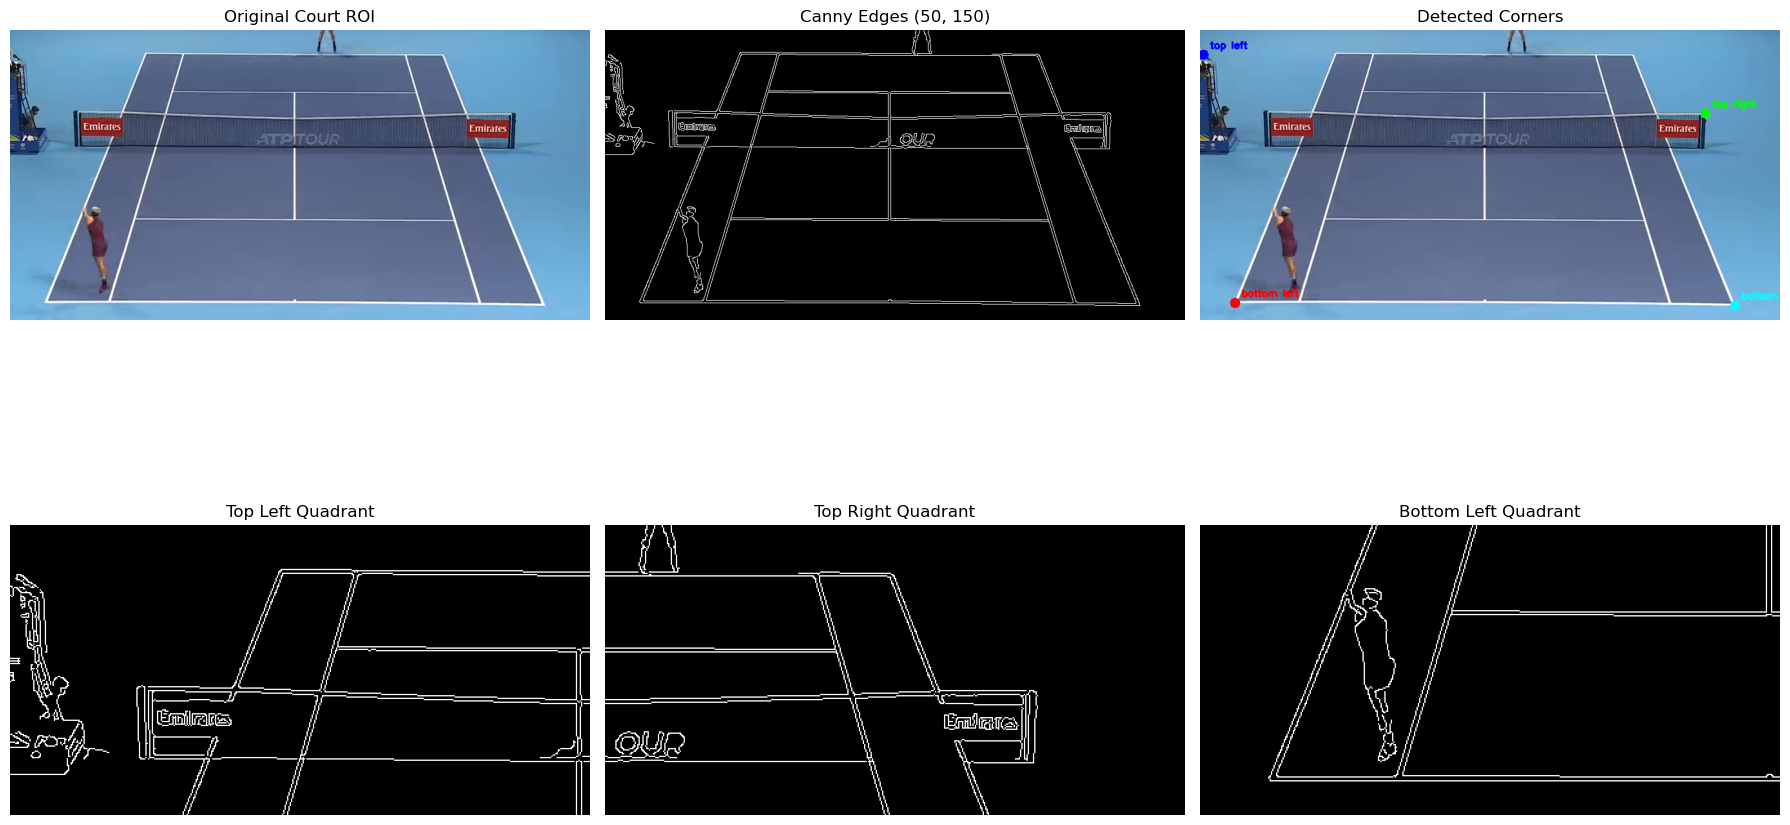

In [18]:
def find_corner_in_quadrant(edges, quadrant_name, corner_type='top-left'):
    """
    Find the most likely corner point in a given quadrant
    corner_type: 'top-left', 'top-right', 'bottom-left', 'bottom-right'
    """
    h, w = edges.shape
    
    # Find all white pixels (edges)
    y_coords, x_coords = np.where(edges > 0)
    
    if len(x_coords) == 0:
        return None
    
    # Based on corner type, find the extreme point
    if corner_type == 'top-left':
        # Find point closest to top-left corner (0,0)
        distances = x_coords + y_coords
        idx = np.argmin(distances)
    elif corner_type == 'top-right':
        # Find point closest to top-right corner (w,0)
        distances = (w - x_coords) + y_coords
        idx = np.argmin(distances)
    elif corner_type == 'bottom-left':
        # Find point closest to bottom-left corner (0,h)
        distances = x_coords + (h - y_coords)
        idx = np.argmin(distances)
    elif corner_type == 'bottom-right':
        # Find point closest to bottom-right corner (w,h)
        distances = (w - x_coords) + (h - y_coords)
        idx = np.argmin(distances)
    
    return (x_coords[idx], y_coords[idx])

# Use the good Canny edges (50, 150) for quadrant analysis
good_edges = cv2.Canny(cv2.GaussianBlur(cv2.cvtColor(court_roi, cv2.COLOR_BGR2GRAY), (5, 5), 0), 50, 150)

# Get dimensions
h, w = good_edges.shape
mid_h, mid_w = h // 2, w // 2

# Divide into quadrants
quadrants = {
    'top_left': good_edges[0:mid_h, 0:mid_w],
    'top_right': good_edges[0:mid_h, mid_w:w],
    'bottom_left': good_edges[mid_h:h, 0:mid_w],
    'bottom_right': good_edges[mid_h:h, mid_w:w]
}

# Find corners in each quadrant
corners = {}
corner_types = ['top-left', 'top-right', 'bottom-left', 'bottom-right']
quadrant_names = ['top_left', 'top_right', 'bottom_left', 'bottom_right']

for i, (quad_name, quad_edges) in enumerate(quadrants.items()):
    corner = find_corner_in_quadrant(quad_edges, quad_name, corner_types[i])
    
    if corner is not None:
        # Adjust coordinates back to full image coordinates
        x, y = corner
        if 'right' in quad_name:
            x += mid_w
        if 'bottom' in quad_name:
            y += mid_h
        corners[quad_name] = (x, y)
    else:
        corners[quad_name] = None

print("Detected corners:")
for quad_name, corner in corners.items():
    if corner:
        print(f"{quad_name}: {corner}")
    else:
        print(f"{quad_name}: Not found")

# Visualize quadrants and corners
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Show original court ROI
axes[0, 0].imshow(cv2.cvtColor(court_roi, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('Original Court ROI')
axes[0, 0].axis('off')

# Show full edges
axes[0, 1].imshow(good_edges, cmap='gray')
axes[0, 1].set_title('Canny Edges (50, 150)')
axes[0, 1].axis('off')

# Show court with detected corners
court_with_corners = court_roi.copy()
corner_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]  # Different colors for each corner

for i, (quad_name, corner) in enumerate(corners.items()):
    if corner:
        x, y = corner
        cv2.circle(court_with_corners, (x, y), 8, corner_colors[i], -1)
        cv2.putText(court_with_corners, quad_name.replace('_', ' '), 
                   (x + 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, corner_colors[i], 2)

axes[0, 2].imshow(cv2.cvtColor(court_with_corners, cv2.COLOR_BGR2RGB))
axes[0, 2].set_title('Detected Corners')
axes[0, 2].axis('off')

# Show individual quadrants
quad_positions = [(1, 0), (1, 1), (1, 2)]
for i, (quad_name, quad_edges) in enumerate(list(quadrants.items())[:3]):
    row, col = quad_positions[i]
    axes[row, col].imshow(quad_edges, cmap='gray')
    axes[row, col].set_title(f'{quad_name.replace("_", " ").title()} Quadrant')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Method 6 Improved: Better Quadrant Corner Detection
Let's analyze why the bottom corners work well and fix the top quadrant detection.

=== QUADRANT EDGE ANALYSIS ===

TOP_LEFT:
  Total edges: 4584
  Edge distribution - Top: 856, Middle: 2154, Bottom: 1574
  Edge distribution - Left: 1787, Center: 1463, Right: 1334
  Y range: 34 to 224
  X range: 0 to 449

TOP_RIGHT:
  Total edges: 3375
  Edge distribution - Top: 660, Middle: 1474, Bottom: 1241
  Edge distribution - Left: 1424, Center: 1517, Right: 434
  Y range: 0 to 224
  X range: 0 to 335

BOTTOM_LEFT:
  Total edges: 2718
  Edge distribution - Top: 1105, Middle: 517, Bottom: 1096
  Edge distribution - Left: 1061, Center: 921, Right: 736
  Y range: 0 to 198
  X range: 53 to 449

BOTTOM_RIGHT:
  Total edges: 2063
  Edge distribution - Top: 784, Middle: 319, Bottom: 960
  Edge distribution - Left: 600, Center: 888, Right: 575
  Y range: 0 to 202
  X range: 0 to 380

=== IMPROVED CORNER DETECTION ===
Original corners:
  top_left: (5, 38)
  top_right: (784, 129)
  bottom_left: (54, 423)
  bottom_right: (830, 427)

Improved corners:
  top_left: (5, 38)
  top_right: None
 

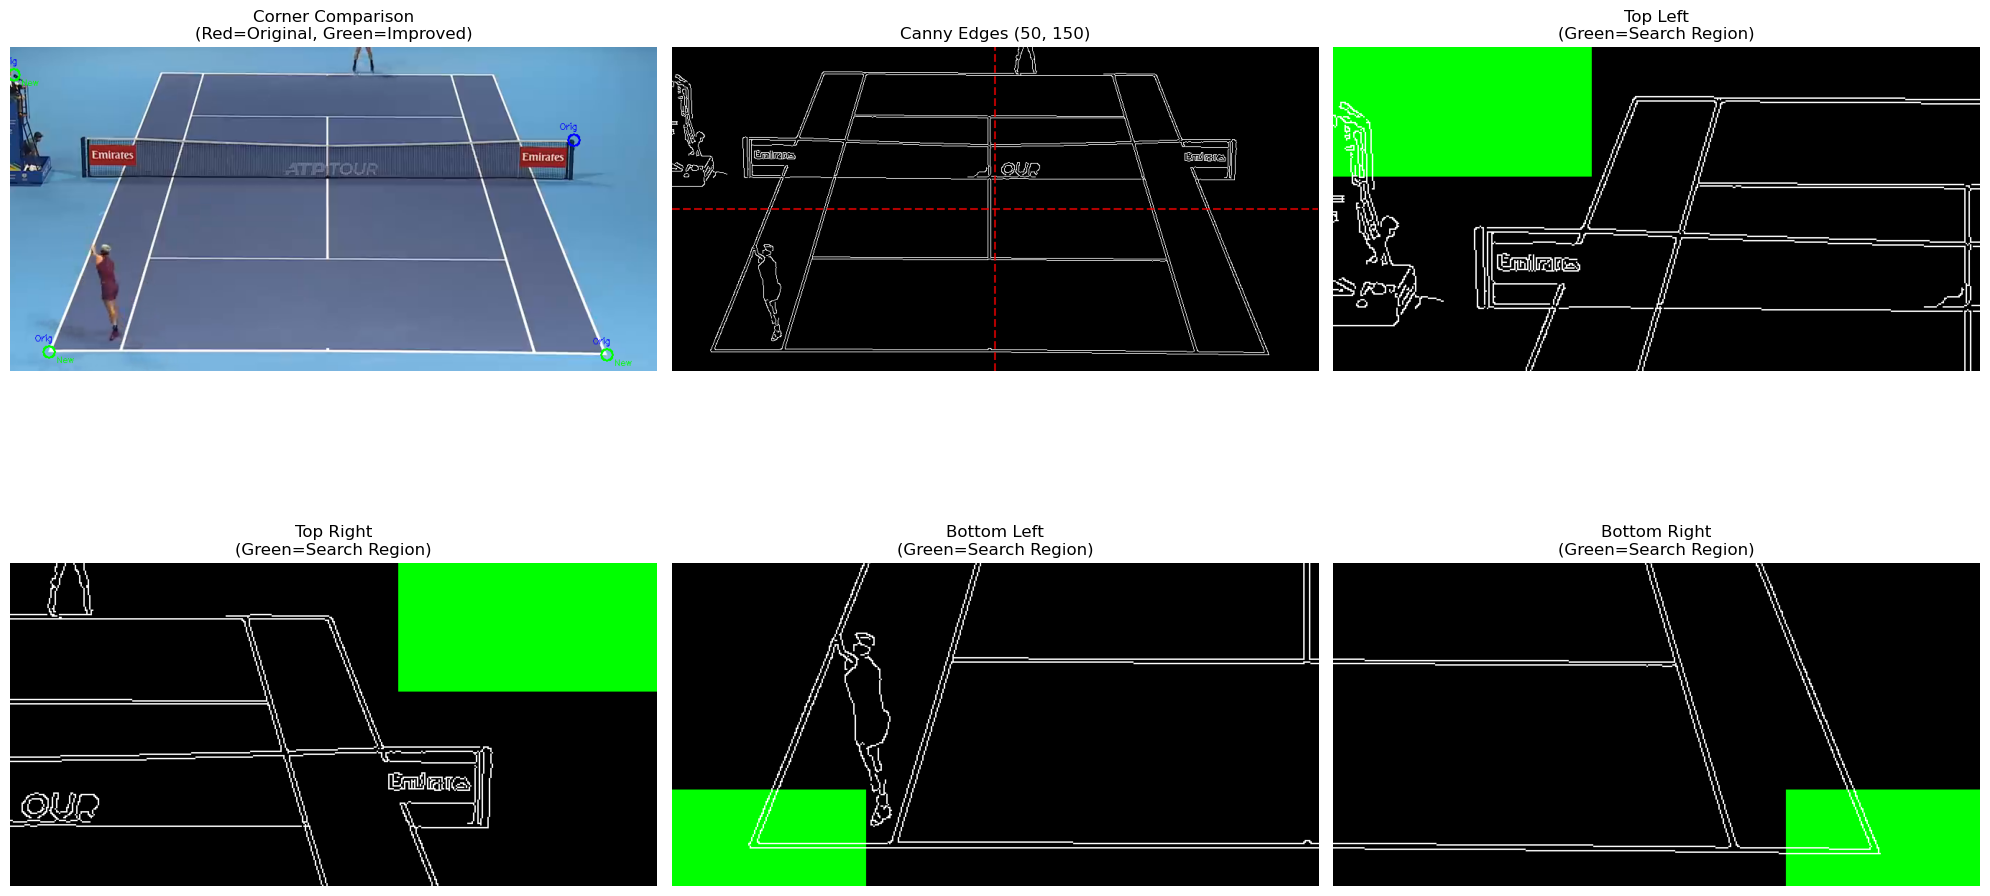

In [21]:
def find_court_corner_improved(edges, corner_type='top-left', search_margin=0.3):
    """
    Improved corner detection that looks for the actual court boundary
    search_margin: fraction of quadrant to search from the edge (0.3 = search in outer 30% of quadrant)
    """
    h, w = edges.shape
    
    # Define search regions based on corner type (focus on outer portions)
    if corner_type == 'top-left':
        # Search in the top-left region, focusing on upper and left edges
        search_h = int(h * search_margin)
        search_w = int(w * search_margin)
        search_region = edges[0:search_h, 0:search_w]
        offset_y, offset_x = 0, 0
        
    elif corner_type == 'top-right':
        # Search in the top-right region, focusing on upper and right edges
        search_h = int(h * search_margin)
        search_w = int(w * search_margin)
        search_region = edges[0:search_h, -search_w:]
        offset_y, offset_x = 0, w - search_w
        
    elif corner_type == 'bottom-left':
        # Search in the bottom-left region, focusing on lower and left edges
        search_h = int(h * search_margin)
        search_w = int(w * search_margin)
        search_region = edges[-search_h:, 0:search_w]
        offset_y, offset_x = h - search_h, 0
        
    elif corner_type == 'bottom-right':
        # Search in the bottom-right region, focusing on lower and right edges
        search_h = int(h * search_margin)
        search_w = int(w * search_margin)
        search_region = edges[-search_h:, -search_w:]
        offset_y, offset_x = h - search_h, w - search_w
    
    # Find edge points in the search region
    y_coords, x_coords = np.where(search_region > 0)
    
    if len(x_coords) == 0:
        return None
    
    # For each corner type, find the most extreme point in the search region
    if corner_type == 'top-left':
        # Find the point that's closest to top-left (0,0) within the search region
        distances = x_coords + y_coords
        idx = np.argmin(distances)
    elif corner_type == 'top-right':
        # Find the point that's closest to top-right within the search region
        distances = (search_w - x_coords) + y_coords
        idx = np.argmin(distances)
    elif corner_type == 'bottom-left':
        # Find the point that's closest to bottom-left within the search region
        distances = x_coords + (search_h - y_coords)
        idx = np.argmin(distances)
    elif corner_type == 'bottom-right':
        # Find the point that's closest to bottom-right within the search region
        distances = (search_w - x_coords) + (search_h - y_coords)
        idx = np.argmin(distances)
    
    # Convert back to full image coordinates
    final_x = x_coords[idx] + offset_x
    final_y = y_coords[idx] + offset_y
    
    return (final_x, final_y)

def analyze_quadrant_edges(edges, quadrant_name):
    """Analyze edge distribution in a quadrant to understand why bottom works better"""
    h, w = edges.shape
    edge_points = np.where(edges > 0)
    
    if len(edge_points[0]) == 0:
        return None
    
    # Analyze edge distribution
    y_coords, x_coords = edge_points
    
    # Count edges in different regions of the quadrant
    top_third = np.sum(y_coords < h // 3)
    middle_third = np.sum((y_coords >= h // 3) & (y_coords < 2 * h // 3))
    bottom_third = np.sum(y_coords >= 2 * h // 3)
    
    left_third = np.sum(x_coords < w // 3)
    center_third = np.sum((x_coords >= w // 3) & (x_coords < 2 * w // 3))
    right_third = np.sum(x_coords >= 2 * w // 3)
    
    return {
        'total_edges': len(y_coords),
        'top_third': top_third,
        'middle_third': middle_third,
        'bottom_third': bottom_third,
        'left_third': left_third,
        'center_third': center_third,
        'right_third': right_third,
        'y_min': np.min(y_coords),
        'y_max': np.max(y_coords),
        'x_min': np.min(x_coords),
        'x_max': np.max(x_coords)
    }

# Use Canny (50, 150) as identified as the best
good_edges = cv2.Canny(cv2.GaussianBlur(cv2.cvtColor(court_roi, cv2.COLOR_BGR2GRAY), (5, 5), 0), 50, 150)

# Get dimensions and create quadrants
h, w = good_edges.shape
mid_h, mid_w = h // 2, w // 2

quadrants = {
    'top_left': good_edges[0:mid_h, 0:mid_w],
    'top_right': good_edges[0:mid_h, mid_w:w],
    'bottom_left': good_edges[mid_h:h, 0:mid_w],
    'bottom_right': good_edges[mid_h:h, mid_w:w]
}

# Analyze each quadrant to understand edge distribution
print("=== QUADRANT EDGE ANALYSIS ===")
for quad_name, quad_edges in quadrants.items():
    analysis = analyze_quadrant_edges(quad_edges, quad_name)
    if analysis:
        print(f"\n{quad_name.upper()}:")
        print(f"  Total edges: {analysis['total_edges']}")
        print(f"  Edge distribution - Top: {analysis['top_third']}, Middle: {analysis['middle_third']}, Bottom: {analysis['bottom_third']}")
        print(f"  Edge distribution - Left: {analysis['left_third']}, Center: {analysis['center_third']}, Right: {analysis['right_third']}")
        print(f"  Y range: {analysis['y_min']} to {analysis['y_max']}")
        print(f"  X range: {analysis['x_min']} to {analysis['x_max']}")

# Find improved corners with different search margins
improved_corners = {}
corner_types = ['top-left', 'top-right', 'bottom-left', 'bottom-right']
quadrant_names = ['top_left', 'top_right', 'bottom_left', 'bottom_right']

# Use different search margins for top and bottom quadrants
search_margins = [0.4, 0.4, 0.3, 0.3]  # Larger search area for top quadrants

for i, (quad_name, quad_edges) in enumerate(quadrants.items()):
    corner = find_court_corner_improved(quad_edges, corner_types[i], search_margins[i])
    
    if corner is not None:
        # Adjust coordinates back to full image coordinates
        x, y = corner
        if 'right' in quad_name:
            x += mid_w
        if 'bottom' in quad_name:
            y += mid_h
        improved_corners[quad_name] = (x, y)
    else:
        improved_corners[quad_name] = None

print("\n=== IMPROVED CORNER DETECTION ===")
print("Original corners:")
for quad_name, corner in corners.items():
    print(f"  {quad_name}: {corner}")

print("\nImproved corners:")
for quad_name, corner in improved_corners.items():
    print(f"  {quad_name}: {corner}")

# Visualize the improved results
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Show original with both corner sets
court_comparison = court_roi.copy()

# Draw original corners in red
for i, (quad_name, corner) in enumerate(corners.items()):
    if corner:
        x, y = corner
        cv2.circle(court_comparison, (x, y), 8, (255, 0, 0), 2)  # Red circles
        cv2.putText(court_comparison, f'Orig', (x - 20, y - 15), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)

# Draw improved corners in green
for i, (quad_name, corner) in enumerate(improved_corners.items()):
    if corner:
        x, y = corner
        cv2.circle(court_comparison, (x, y), 8, (0, 255, 0), 2)  # Green circles
        cv2.putText(court_comparison, f'New', (x + 10, y + 15), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)

axes[0, 0].imshow(cv2.cvtColor(court_comparison, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('Corner Comparison\n(Red=Original, Green=Improved)')
axes[0, 0].axis('off')

# Show the edge analysis for each quadrant
axes[0, 1].imshow(good_edges, cmap='gray')
axes[0, 1].set_title('Canny Edges (50, 150)')
axes[0, 1].axhline(y=mid_h, color='red', linestyle='--', alpha=0.7)
axes[0, 1].axvline(x=mid_w, color='red', linestyle='--', alpha=0.7)
axes[0, 1].axis('off')

# Show individual quadrants with analysis
quad_positions = [(0, 2), (1, 0), (1, 1), (1, 2)]
for i, (quad_name, quad_edges) in enumerate(quadrants.items()):
    row, col = quad_positions[i]
    
    # Create visualization showing search regions
    quad_viz = np.stack([quad_edges, quad_edges, quad_edges], axis=-1)
    
    # Highlight search region for this quadrant
    h_q, w_q = quad_edges.shape
    margin = search_margins[i]
    
    if 'top' in quad_name and 'left' in quad_name:
        search_h, search_w = int(h_q * margin), int(w_q * margin)
        quad_viz[0:search_h, 0:search_w, 1] = 255  # Green tint
    elif 'top' in quad_name and 'right' in quad_name:
        search_h, search_w = int(h_q * margin), int(w_q * margin)
        quad_viz[0:search_h, -search_w:, 1] = 255
    elif 'bottom' in quad_name and 'left' in quad_name:
        search_h, search_w = int(h_q * margin), int(w_q * margin)
        quad_viz[-search_h:, 0:search_w, 1] = 255
    elif 'bottom' in quad_name and 'right' in quad_name:
        search_h, search_w = int(h_q * margin), int(w_q * margin)
        quad_viz[-search_h:, -search_w:, 1] = 255
    
    axes[row, col].imshow(quad_viz)
    axes[row, col].set_title(f'{quad_name.replace("_", " ").title()}\n(Green=Search Region)')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Method 8: Outer Boundary Line Detection
Let's focus specifically on finding the outermost lines in each quadrant, since Canny detects both sides of white lines.

=== OUTER BOUNDARY CORNER DETECTION ===
top_left: (0, 47)
top_right: (784, 129)
bottom_left: (54, 423)
bottom_right: (830, 427)

Validation: Valid court shape detected


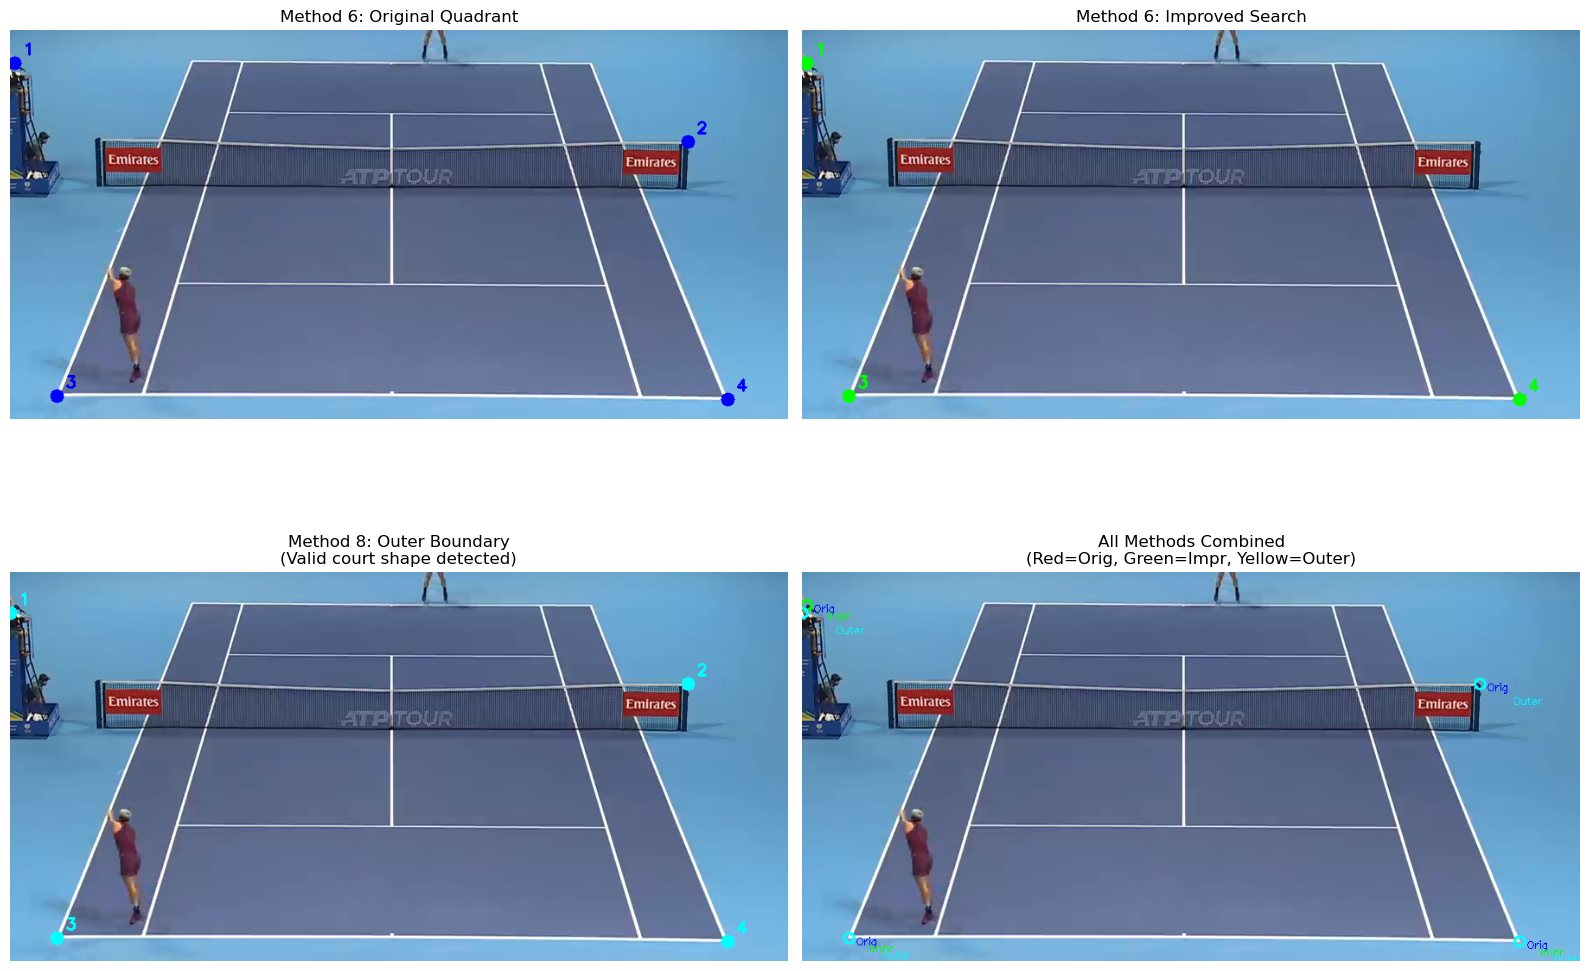


=== COMPARISON OF ALL CORNER METHODS ===
Original Method 6:
  top_left: (5, 38)
  top_right: (784, 129)
  bottom_left: (54, 423)
  bottom_right: (830, 427)

Improved Method 6:
  top_left: (5, 38)
  top_right: None
  bottom_left: (54, 423)
  bottom_right: (830, 427)

Method 8 (Outer Boundary):
  top_left: (0, 47)
  top_right: (784, 129)
  bottom_left: (54, 423)
  bottom_right: (830, 427)

=== FINAL RECOMMENDATION ===
Best corner detection method: Method 8 (Outer Boundary)
Successfully extracted 4 corner points for court perimeter!


In [22]:
def find_outer_boundary_corner(quad_edges, corner_type='top-left'):
    """
    Find corner by detecting the outermost lines in each quadrant
    This accounts for Canny detecting both sides of white lines
    """
    h, w = quad_edges.shape
    
    if corner_type == 'top-left':
        # Look for the topmost and leftmost edges
        # Find topmost edge pixels
        top_edges = []
        for y in range(h):
            x_coords = np.where(quad_edges[y, :] > 0)[0]
            if len(x_coords) > 0:
                top_edges.extend([(x, y) for x in x_coords])
                if len(top_edges) > 50:  # Stop after finding enough points
                    break
        
        # Find leftmost edge pixels
        left_edges = []
        for x in range(w):
            y_coords = np.where(quad_edges[:, x] > 0)[0]
            if len(y_coords) > 0:
                left_edges.extend([(x, y) for y in y_coords])
                if len(left_edges) > 50:
                    break
        
        # Combine and find the point that's both high and left
        all_edges = top_edges + left_edges
        if not all_edges:
            return None
        
        # Find point closest to (0,0)
        distances = [x + y for x, y in all_edges]
        min_idx = np.argmin(distances)
        return all_edges[min_idx]
        
    elif corner_type == 'top-right':
        # Look for the topmost and rightmost edges
        top_edges = []
        for y in range(h):
            x_coords = np.where(quad_edges[y, :] > 0)[0]
            if len(x_coords) > 0:
                top_edges.extend([(x, y) for x in x_coords])
                if len(top_edges) > 50:
                    break
        
        # Find rightmost edge pixels (scan from right to left)
        right_edges = []
        for x in range(w-1, -1, -1):
            y_coords = np.where(quad_edges[:, x] > 0)[0]
            if len(y_coords) > 0:
                right_edges.extend([(x, y) for y in y_coords])
                if len(right_edges) > 50:
                    break
        
        all_edges = top_edges + right_edges
        if not all_edges:
            return None
        
        # Find point closest to (w, 0)
        distances = [(w - x) + y for x, y in all_edges]
        min_idx = np.argmin(distances)
        return all_edges[min_idx]
        
    elif corner_type == 'bottom-left':
        # Look for the bottommost and leftmost edges
        bottom_edges = []
        for y in range(h-1, -1, -1):
            x_coords = np.where(quad_edges[y, :] > 0)[0]
            if len(x_coords) > 0:
                bottom_edges.extend([(x, y) for x in x_coords])
                if len(bottom_edges) > 50:
                    break
        
        left_edges = []
        for x in range(w):
            y_coords = np.where(quad_edges[:, x] > 0)[0]
            if len(y_coords) > 0:
                left_edges.extend([(x, y) for y in y_coords])
                if len(left_edges) > 50:
                    break
        
        all_edges = bottom_edges + left_edges
        if not all_edges:
            return None
        
        # Find point closest to (0, h)
        distances = [x + (h - y) for x, y in all_edges]
        min_idx = np.argmin(distances)
        return all_edges[min_idx]
        
    elif corner_type == 'bottom-right':
        # Look for the bottommost and rightmost edges
        bottom_edges = []
        for y in range(h-1, -1, -1):
            x_coords = np.where(quad_edges[y, :] > 0)[0]
            if len(x_coords) > 0:
                bottom_edges.extend([(x, y) for x in x_coords])
                if len(bottom_edges) > 50:
                    break
        
        right_edges = []
        for x in range(w-1, -1, -1):
            y_coords = np.where(quad_edges[:, x] > 0)[0]
            if len(y_coords) > 0:
                right_edges.extend([(x, y) for y in y_coords])
                if len(right_edges) > 50:
                    break
        
        all_edges = bottom_edges + right_edges
        if not all_edges:
            return None
        
        # Find point closest to (w, h)
        distances = [(w - x) + (h - y) for x, y in all_edges]
        min_idx = np.argmin(distances)
        return all_edges[min_idx]

# Apply the outer boundary method
outer_boundary_corners = {}
corner_types = ['top-left', 'top-right', 'bottom-left', 'bottom-right']
quadrant_names = ['top_left', 'top_right', 'bottom_left', 'bottom_right']

for i, (quad_name, quad_edges) in enumerate(quadrants.items()):
    corner = find_outer_boundary_corner(quad_edges, corner_types[i])
    
    if corner is not None:
        # Adjust coordinates back to full image coordinates
        x, y = corner
        if 'right' in quad_name:
            x += mid_w
        if 'bottom' in quad_name:
            y += mid_h
        outer_boundary_corners[quad_name] = (x, y)
    else:
        outer_boundary_corners[quad_name] = None

print("=== OUTER BOUNDARY CORNER DETECTION ===")
for quad_name, corner in outer_boundary_corners.items():
    if corner:
        print(f"{quad_name}: {corner}")
    else:
        print(f"{quad_name}: Not found")

# Validate the outer boundary corners
valid_outer, msg_outer = validate_court_shape(outer_boundary_corners)
print(f"\nValidation: {msg_outer}")

# Create final comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Method 6 Original
court_method6 = court_roi.copy()
for i, (quad_name, corner) in enumerate(corners.items()):
    if corner:
        x, y = corner
        cv2.circle(court_method6, (x, y), 8, (255, 0, 0), -1)
        cv2.putText(court_method6, f'{i+1}', (x + 10, y - 10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

axes[0, 0].imshow(cv2.cvtColor(court_method6, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('Method 6: Original Quadrant')
axes[0, 0].axis('off')

# Method 6 Improved
court_improved = court_roi.copy()
for i, (quad_name, corner) in enumerate(improved_corners.items()):
    if corner:
        x, y = corner
        cv2.circle(court_improved, (x, y), 8, (0, 255, 0), -1)
        cv2.putText(court_improved, f'{i+1}', (x + 10, y - 10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

axes[0, 1].imshow(cv2.cvtColor(court_improved, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title('Method 6: Improved Search')
axes[0, 1].axis('off')

# Method 8 Outer Boundary
court_outer = court_roi.copy()
for i, (quad_name, corner) in enumerate(outer_boundary_corners.items()):
    if corner:
        x, y = corner
        cv2.circle(court_outer, (x, y), 8, (255, 255, 0), -1)
        cv2.putText(court_outer, f'{i+1}', (x + 10, y - 10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

axes[1, 0].imshow(cv2.cvtColor(court_outer, cv2.COLOR_BGR2RGB))
axes[1, 0].set_title(f'Method 8: Outer Boundary\n({msg_outer})')
axes[1, 0].axis('off')

# Combined comparison
court_combined = court_roi.copy()
# Draw all three methods with different colors
colors = [(255, 0, 0), (0, 255, 0), (255, 255, 0)]
methods = [corners, improved_corners, outer_boundary_corners]
labels = ['Orig', 'Impr', 'Outer']

for method_idx, (method_corners, color, label) in enumerate(zip(methods, colors, labels)):
    for quad_name, corner in method_corners.items():
        if corner:
            x, y = corner
            cv2.circle(court_combined, (x, y), 6, color, 2)
            cv2.putText(court_combined, label, 
                       (x + 8 + method_idx * 15, y + 8 + method_idx * 8), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

axes[1, 1].imshow(cv2.cvtColor(court_combined, cv2.COLOR_BGR2RGB))
axes[1, 1].set_title('All Methods Combined\n(Red=Orig, Green=Impr, Yellow=Outer)')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("\n=== COMPARISON OF ALL CORNER METHODS ===")
print("Original Method 6:")
for quad_name, corner in corners.items():
    print(f"  {quad_name}: {corner}")

print("\nImproved Method 6:")
for quad_name, corner in improved_corners.items():
    print(f"  {quad_name}: {corner}")

print("\nMethod 8 (Outer Boundary):")
for quad_name, corner in outer_boundary_corners.items():
    print(f"  {quad_name}: {corner}")

# Choose the best corner set
if valid_outer:
    best_corners_final = outer_boundary_corners
    best_method_name = "Method 8 (Outer Boundary)"
else:
    # Compare improved vs original
    valid_improved, msg_improved = validate_court_shape(improved_corners)
    if valid_improved:
        best_corners_final = improved_corners
        best_method_name = "Method 6 (Improved)"
    else:
        best_corners_final = corners
        best_method_name = "Method 6 (Original)"

print(f"\n=== FINAL RECOMMENDATION ===")
print(f"Best corner detection method: {best_method_name}")
perimeter_final = extract_court_perimeter(best_corners_final)
if perimeter_final is not None:
    print(f"Successfully extracted {len(perimeter_final)} corner points for court perimeter!")

# Method 9: Perspective-Aware Corner Detection
The court is in perspective - wider at bottom, narrower at top. Let's adjust corner detection accordingly.

=== PERSPECTIVE-AWARE CORNER DETECTION ===
top_left: (210, 34)
top_right: (671, 37)
bottom_left: (54, 423)
bottom_right: (830, 427)

Validation: Valid court shape detected


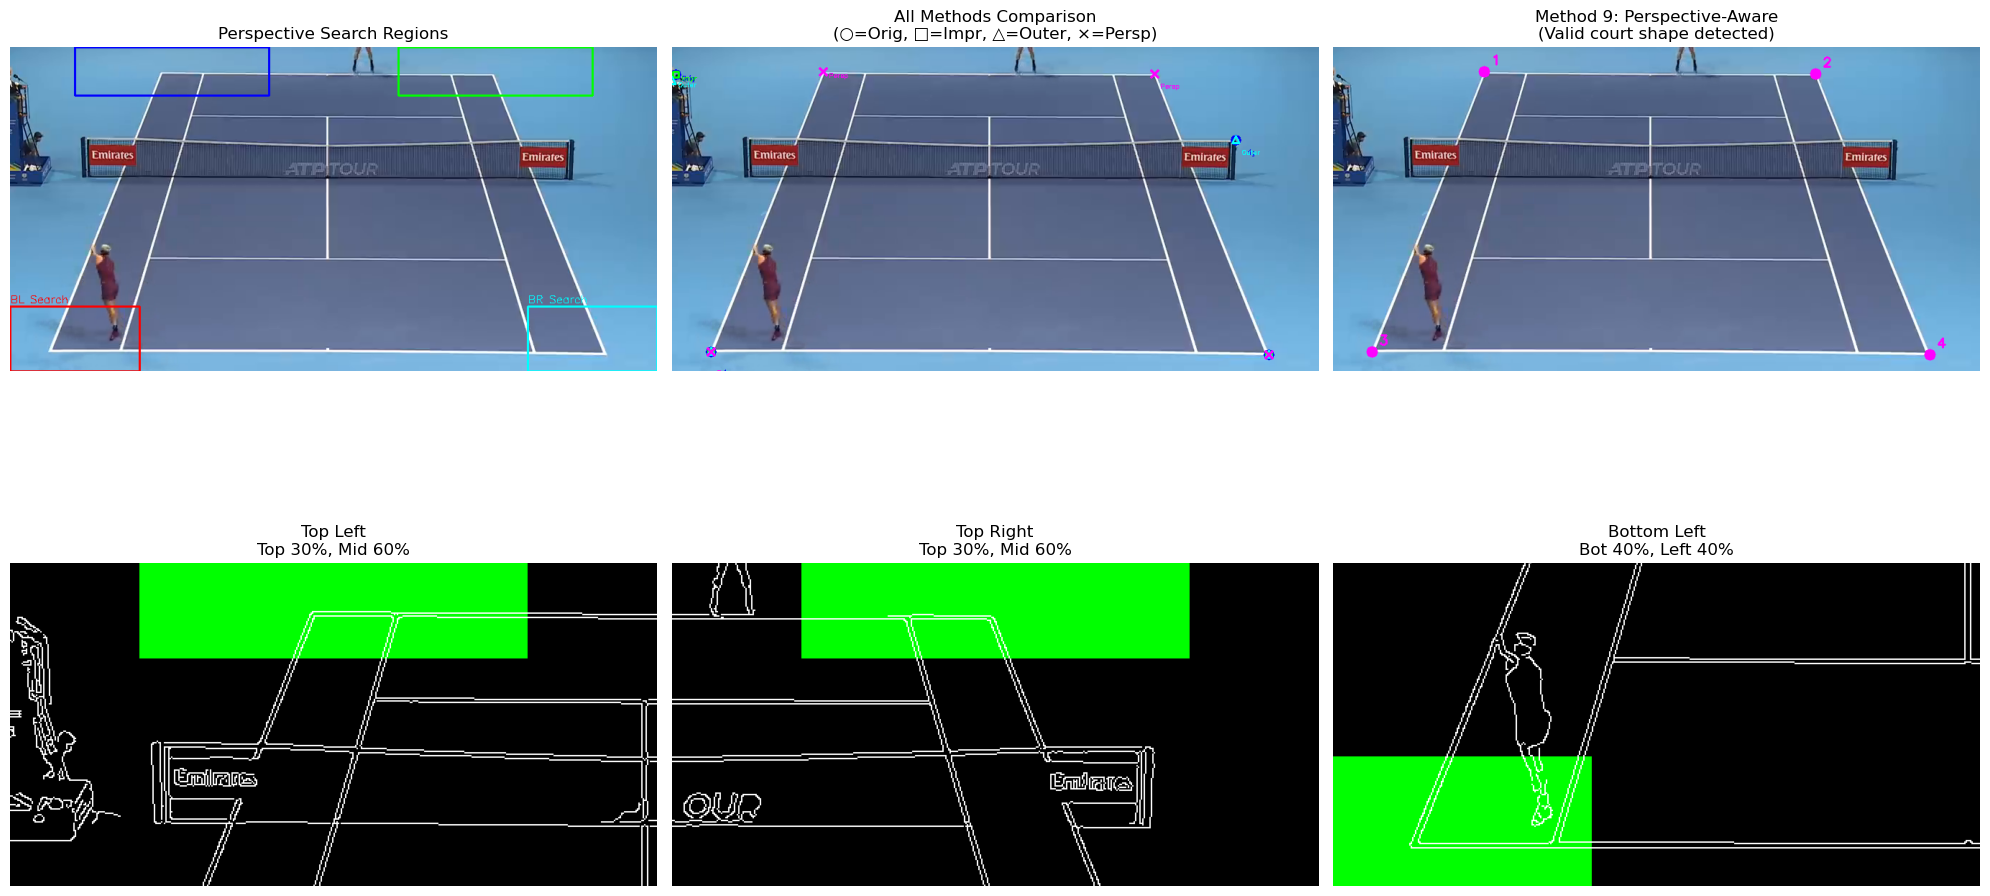


=== PERSPECTIVE CORNER ANALYSIS ===
The perspective-aware method accounts for:
- Top corners: More centered horizontally due to perspective
- Top corners: Prioritize being in upper portion of quadrant
- Bottom corners: Can use wider search as they're closer to camera
- Scoring: Heavily weights Y position for top corners, balanced for bottom

=== ALL CORNER METHODS COMPARISON ===

Original:
  Validation: Valid court shape detected
  top_left: (5, 38)
  top_right: (784, 129)
  bottom_left: (54, 423)
  bottom_right: (830, 427)

Improved:
  Validation: Not all corners detected
  top_left: (5, 38)
  top_right: None
  bottom_left: (54, 423)
  bottom_right: (830, 427)

Outer Boundary:
  Validation: Valid court shape detected
  top_left: (0, 47)
  top_right: (784, 129)
  bottom_left: (54, 423)
  bottom_right: (830, 427)

Perspective-Aware:
  Validation: Valid court shape detected
  top_left: (210, 34)
  top_right: (671, 37)
  bottom_left: (54, 423)
  bottom_right: (830, 427)

=== FINAL RECOMM

In [ ]:
def find_perspective_corner(quad_edges, corner_type='top-left'):
    """
    Find corners accounting for tennis court perspective:
    - Top corners are more centered horizontally (perspective narrowing)
    - Bottom corners are more towards the actual edges
    - Top corners should be in upper portion but not extreme edges
    """
    h, w = quad_edges.shape
    
    if corner_type == 'top-left':
        # For top-left: look in top portion but more centered horizontally
        # Search in top 30% of height, but middle 60% of width (not far left)
        search_h = int(h * 0.3)  # Top 30%
        search_w_start = int(w * 0.2)  # Start from 20% in from left
        search_w_end = int(w * 0.8)    # End at 80% (middle 60% of width)
        
        search_region = quad_edges[0:search_h, search_w_start:search_w_end]
        offset_y, offset_x = 0, search_w_start
        
        # Find edge points in search region
        y_coords, x_coords = np.where(search_region > 0)
        if len(x_coords) == 0:
            return None
        
        # For top-left in perspective: prioritize TOP position, then left-ish position
        # Weight heavily towards top, moderately towards left within the search region
        search_h_reg, search_w_reg = search_region.shape
        scores = (search_h_reg - y_coords) * 3 + (search_w_reg - x_coords) * 1
        best_idx = np.argmax(scores)
        
        final_x = x_coords[best_idx] + offset_x
        final_y = y_coords[best_idx] + offset_y
        
    elif corner_type == 'top-right':
        # For top-right: look in top portion but more centered horizontally  
        search_h = int(h * 0.3)  # Top 30%
        search_w_start = int(w * 0.2)  # Start from 20% in from left
        search_w_end = int(w * 0.8)    # End at 80% (middle 60% of width)
        
        search_region = quad_edges[0:search_h, search_w_start:search_w_end]
        offset_y, offset_x = 0, search_w_start
        
        y_coords, x_coords = np.where(search_region > 0)
        if len(x_coords) == 0:
            return None
        
        # For top-right in perspective: prioritize TOP position, then right-ish position
        search_h_reg, search_w_reg = search_region.shape
        scores = (search_h_reg - y_coords) * 3 + x_coords * 1
        best_idx = np.argmax(scores)
        
        final_x = x_coords[best_idx] + offset_x
        final_y = y_coords[best_idx] + offset_y
        
    elif corner_type == 'bottom-left':
        # Bottom corners can use the full width as they're closer to camera
        search_h = int(h * 0.4)  # Bottom 40%
        search_w = int(w * 0.4)  # Left 40%
        
        search_region = quad_edges[-search_h:, 0:search_w]
        offset_y, offset_x = h - search_h, 0
        
        y_coords, x_coords = np.where(search_region > 0)
        if len(x_coords) == 0:
            return None
        
        # For bottom-left: prioritize bottom and left positions equally
        search_h_reg, search_w_reg = search_region.shape
        scores = y_coords * 2 + (search_w_reg - x_coords) * 2
        best_idx = np.argmax(scores)
        
        final_x = x_coords[best_idx] + offset_x
        final_y = y_coords[best_idx] + offset_y
        
    elif corner_type == 'bottom-right':
        # Bottom corners can use the full width as they're closer to camera
        search_h = int(h * 0.4)  # Bottom 40%
        search_w = int(w * 0.4)  # Right 40%
        
        search_region = quad_edges[-search_h:, -search_w:]
        offset_y, offset_x = h - search_h, w - search_w
        
        y_coords, x_coords = np.where(search_region > 0)
        if len(x_coords) == 0:
            return None
        
        # For bottom-right: prioritize bottom and right positions equally
        search_h_reg, search_w_reg = search_region.shape
        scores = y_coords * 2 + x_coords * 2
        best_idx = np.argmax(scores)
        
        final_x = x_coords[best_idx] + offset_x
        final_y = y_coords[best_idx] + offset_y
    
    return (final_x, final_y)

# Apply the perspective-aware corner detection
perspective_corners = {}
corner_types = ['top-left', 'top-right', 'bottom-left', 'bottom-right']
quadrant_names = ['top_left', 'top_right', 'bottom_left', 'bottom_right']

for i, (quad_name, quad_edges) in enumerate(quadrants.items()):
    corner = find_perspective_corner(quad_edges, corner_types[i])
    
    if corner is not None:
        # Adjust coordinates back to full image coordinates
        x, y = corner
        if 'right' in quad_name:
            x += mid_w
        if 'bottom' in quad_name:
            y += mid_h
        perspective_corners[quad_name] = (x, y)
    else:
        perspective_corners[quad_name] = None

print("=== PERSPECTIVE-AWARE CORNER DETECTION ===")
for quad_name, corner in perspective_corners.items():
    if corner:
        print(f"{quad_name}: {corner}")
    else:
        print(f"{quad_name}: Not found")

# Validate the perspective corners
valid_perspective, msg_perspective = validate_court_shape(perspective_corners)
print(f"\nValidation: {msg_perspective}")

# Create detailed comparison visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Show search regions for perspective method
court_search_viz = court_roi.copy()

# Overlay search regions with different colors
h, w = good_edges.shape
mid_h, mid_w = h // 2, w // 2

# Top-left search region (top 30%, middle 60% horizontally)
tl_y1, tl_y2 = 0, int(mid_h * 0.3)
tl_x1, tl_x2 = int(mid_w * 0.2), int(mid_w * 0.8)
cv2.rectangle(court_search_viz, (tl_x1, tl_y1), (tl_x2, tl_y2), (255, 0, 0), 2)
cv2.putText(court_search_viz, 'TL Search', (tl_x1, tl_y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

# Top-right search region (top 30%, middle 60% horizontally)
tr_y1, tr_y2 = 0, int(mid_h * 0.3)
tr_x1, tr_x2 = mid_w + int(mid_w * 0.2), mid_w + int(mid_w * 0.8)
cv2.rectangle(court_search_viz, (tr_x1, tr_y1), (tr_x2, tr_y2), (0, 255, 0), 2)
cv2.putText(court_search_viz, 'TR Search', (tr_x1, tr_y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

# Bottom-left search region (bottom 40%, left 40%)
bl_y1, bl_y2 = mid_h + int(mid_h * 0.6), h
bl_x1, bl_x2 = 0, int(mid_w * 0.4)
cv2.rectangle(court_search_viz, (bl_x1, bl_y1), (bl_x2, bl_y2), (0, 0, 255), 2)
cv2.putText(court_search_viz, 'BL Search', (bl_x1, bl_y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

# Bottom-right search region (bottom 40%, right 40%)
br_y1, br_y2 = mid_h + int(mid_h * 0.6), h
br_x1, br_x2 = mid_w + int(mid_w * 0.6), w
cv2.rectangle(court_search_viz, (br_x1, br_y1), (br_x2, br_y2), (255, 255, 0), 2)
cv2.putText(court_search_viz, 'BR Search', (br_x1, br_y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

axes[0, 0].imshow(cv2.cvtColor(court_search_viz, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('Perspective Search Regions')
axes[0, 0].axis('off')

# Show all corner methods comparison
court_all_methods = court_roi.copy()

# Draw different methods with different shapes and colors
methods_data = [
    (corners, (255, 0, 0), 'o', 'Orig'),           # Red circles
    (improved_corners, (0, 255, 0), 's', 'Impr'),  # Green squares  
    (outer_boundary_corners, (255, 255, 0), '^', 'Outer'), # Yellow triangles
    (perspective_corners, (255, 0, 255), 'x', 'Persp')     # Magenta X
]

for method_corners, color, marker, label in methods_data:
    for i, (quad_name, corner) in enumerate(method_corners.items()):
        if corner:
            x, y = corner
            if marker == 'o':
                cv2.circle(court_all_methods, (x, y), 6, color, 2)
            elif marker == 's':
                cv2.rectangle(court_all_methods, (x-4, y-4), (x+4, y+4), color, 2)
            elif marker == '^':
                pts = np.array([[x, y-6], [x-5, y+4], [x+5, y+4]], np.int32)
                cv2.polylines(court_all_methods, [pts], True, color, 2)
            elif marker == 'x':
                cv2.line(court_all_methods, (x-5, y-5), (x+5, y+5), color, 2)
                cv2.line(court_all_methods, (x-5, y+5), (x+5, y-5), color, 2)
            
            # Add label
            cv2.putText(court_all_methods, label, 
                       (x + 8, y + 8 + i * 12), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.3, color, 1)

axes[0, 1].imshow(cv2.cvtColor(court_all_methods, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title('All Methods Comparison\n(○=Orig, □=Impr, △=Outer, ×=Persp)')
axes[0, 1].axis('off')

# Method 9 result
court_perspective = court_roi.copy()
for i, (quad_name, corner) in enumerate(perspective_corners.items()):
    if corner:
        x, y = corner
        cv2.circle(court_perspective, (x, y), 8, (255, 0, 255), -1)
        cv2.putText(court_perspective, f'{i+1}', (x + 10, y - 10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 255), 2)

axes[0, 2].imshow(cv2.cvtColor(court_perspective, cv2.COLOR_BGR2RGB))
axes[0, 2].set_title(f'Method 9: Perspective-Aware\n({msg_perspective})')
axes[0, 2].axis('off')

# Show quadrants with search areas highlighted
quad_positions = [(1, 0), (1, 1), (1, 2)]
search_params = [
    ("top_left", 0.3, 0.2, 0.8, "Top 30%, Mid 60%"),
    ("top_right", 0.3, 0.2, 0.8, "Top 30%, Mid 60%"), 
    ("bottom_left", 0.4, 0.0, 0.4, "Bot 40%, Left 40%")
]

for i, ((quad_name, quad_edges), (row, col), (search_name, h_frac, w_start, w_end, desc)) in enumerate(zip(list(quadrants.items())[:3], quad_positions, search_params)):
    quad_viz = np.stack([quad_edges, quad_edges, quad_edges], axis=-1)
    
    h_q, w_q = quad_edges.shape
    
    if 'top' in search_name:
        search_h = int(h_q * h_frac)
        search_w_start = int(w_q * w_start) if w_start > 0 else 0
        search_w_end = int(w_q * w_end) if w_end < 1 else w_q
        quad_viz[0:search_h, search_w_start:search_w_end, 1] = 255  # Green overlay
    else:  # bottom
        search_h = int(h_q * h_frac)
        search_w = int(w_q * w_end)
        quad_viz[-search_h:, 0:search_w, 1] = 255
    
    axes[row, col].imshow(quad_viz)
    axes[row, col].set_title(f'{quad_name.replace("_", " ").title()}\n{desc}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print("\n=== PERSPECTIVE CORNER ANALYSIS ===")
print("The perspective-aware method accounts for:")
print("- Top corners: More centered horizontally due to perspective")
print("- Top corners: Prioritize being in upper portion of quadrant")  
print("- Bottom corners: Can use wider search as they're closer to camera")
print("- Scoring: Heavily weights Y position for top corners, balanced for bottom")

print("\n=== ALL CORNER METHODS COMPARISON ===")
methods_names = ["Original", "Improved", "Outer Boundary", "Perspective-Aware"]
all_methods = [corners, improved_corners, outer_boundary_corners, perspective_corners]
validations = [
    validate_court_shape(corners),
    validate_court_shape(improved_corners), 
    validate_court_shape(outer_boundary_corners),
    validate_court_shape(perspective_corners)
]

for method_name, method_corners, (is_valid, msg) in zip(methods_names, all_methods, validations):
    print(f"\n{method_name}:")
    print(f"  Validation: {msg}")
    for quad_name, corner in method_corners.items():
        print(f"  {quad_name}: {corner}")

# Choose the best method
valid_methods = [(name, corners, valid) for name, corners, (valid, msg) in zip(methods_names, all_methods, validations) if valid]

if valid_methods:
    # If multiple valid, prefer perspective-aware, then outer boundary
    if any("Perspective" in name for name, _, _ in valid_methods):
        best_corners_final = perspective_corners
        best_method_name = "Method 9 (Perspective-Aware)"
    elif any("Outer" in name for name, _, _ in valid_methods):
        best_corners_final = outer_boundary_corners  
        best_method_name = "Method 8 (Outer Boundary)"
    else:
        best_corners_final = valid_methods[0][1]
        best_method_name = valid_methods[0][0]
else:
    best_corners_final = perspective_corners
    best_method_name = "Method 9 (Perspective-Aware) - Best attempt"

print(f"\n=== FINAL RECOMMENDATION ===")
print(f"Best corner detection method: {best_method_name}")

perimeter_final = extract_court_perimeter(best_corners_final)
if perimeter_final is not None:
    print(f"Successfully extracted {len(perimeter_final)} corner points!")
    print("Perimeter coordinates:", perimeter_final.tolist())
else:
    print("Could not extract valid perimeter.")

# Method 7: Line Intersection Corner Detection
Let's improve corner detection by finding intersections of horizontal and vertical lines in each quadrant.

Found 97 horizontal lines and 7 vertical lines


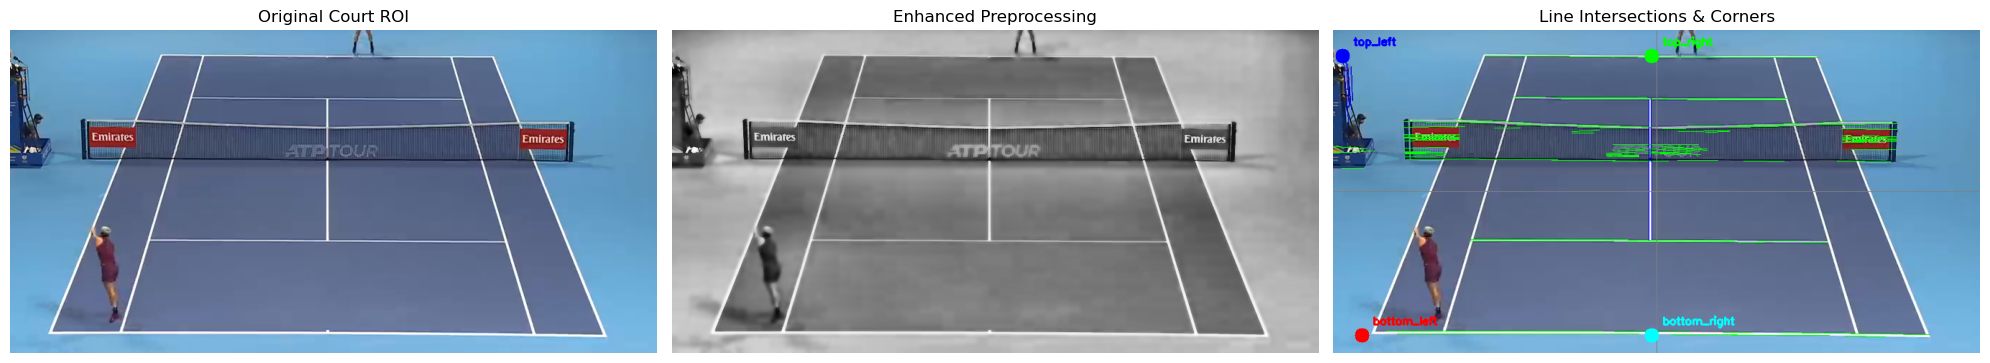

Corner intersections found:
top_left: (13, 37)
top_right: (443, 37)
bottom_left: (40, 425)
bottom_right: (443, 425)


In [27]:
def line_intersection(line1, line2):
    """Find intersection point of two lines"""
    x1, y1, x2, y2 = line1[0]
    x3, y3, x4, y4 = line2[0]
    
    denom = (x1-x2)*(y3-y4) - (y1-y2)*(x3-x4)
    if abs(denom) < 1e-10:
        return None  # Lines are parallel
    
    t = ((x1-x3)*(y3-y4) - (y1-y3)*(x3-x4)) / denom
    
    # Calculate intersection point
    px = x1 + t * (x2-x1)
    py = y1 + t * (y2-y1)
    
    return (int(px), int(py))

def find_court_corners_by_intersection(court_image):
    """Find court corners by detecting line intersections in quadrants"""
    
    # Use enhanced preprocessing
    preprocessed = preprocess_court_image(court_image)
    edges = cv2.Canny(preprocessed, 50, 150, apertureSize=3)
    
    # Detect all lines
    all_lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=40, minLineLength=30, maxLineGap=8)
    
    if all_lines is None:
        return {}, court_image.copy()
    
    # Separate horizontal and vertical lines
    horizontal_lines = []
    vertical_lines = []
    
    for line in all_lines:
        x1, y1, x2, y2 = line[0]
        
        # Calculate angle
        if x2 - x1 == 0:  # Vertical line
            angle = 90
        else:
            angle = np.abs(np.arctan((y2 - y1) / (x2 - x1)) * 180 / np.pi)
        
        # Classify lines
        if angle <= 15:  # Horizontal line
            horizontal_lines.append(line)
        elif angle >= 75:  # Vertical line
            vertical_lines.append(line)
    
    print(f"Found {len(horizontal_lines)} horizontal lines and {len(vertical_lines)} vertical lines")
    
    # Get image dimensions
    h, w = court_image.shape[:2]
    mid_h, mid_w = h // 2, w // 2
    
    # Find intersections in each quadrant
    corner_intersections = {}
    
    # Define quadrant boundaries
    quadrant_bounds = {
        'top_left': (0, mid_w, 0, mid_h),
        'top_right': (mid_w, w, 0, mid_h),
        'bottom_left': (0, mid_w, mid_h, h),
        'bottom_right': (mid_w, w, mid_h, h)
    }
    
    for quad_name, (x_min, x_max, y_min, y_max) in quadrant_bounds.items():
        best_intersection = None
        min_distance_to_corner = float('inf')
        
        # Define the ideal corner position for this quadrant
        if quad_name == 'top_left':
            target_corner = (0, 0)
        elif quad_name == 'top_right':
            target_corner = (w, 0)
        elif quad_name == 'bottom_left':
            target_corner = (0, h)
        else:  # bottom_right
            target_corner = (w, h)
        
        # Find intersections between horizontal and vertical lines in this quadrant
        for h_line in horizontal_lines:
            for v_line in vertical_lines:
                intersection = line_intersection(h_line, v_line)
                
                if intersection is not None:
                    px, py = intersection
                    
                    # Check if intersection is within this quadrant (with some tolerance)
                    if (x_min - 20 <= px <= x_max + 20 and 
                        y_min - 20 <= py <= y_max + 20):
                        
                        # Calculate distance to ideal corner
                        distance = np.sqrt((px - target_corner[0])**2 + (py - target_corner[1])**2)
                        
                        if distance < min_distance_to_corner:
                            min_distance_to_corner = distance
                            best_intersection = (px, py)
        
        corner_intersections[quad_name] = best_intersection
    
    # Draw results
    result_image = court_image.copy()
    
    # Draw all lines
    for line in horizontal_lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(result_image, (x1, y1), (x2, y2), (0, 255, 0), 1)
    
    for line in vertical_lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(result_image, (x1, y1), (x2, y2), (255, 0, 0), 1)
    
    # Draw quadrant boundaries
    cv2.line(result_image, (mid_w, 0), (mid_w, h), (128, 128, 128), 1)
    cv2.line(result_image, (0, mid_h), (w, mid_h), (128, 128, 128), 1)
    
    # Draw corner intersections
    corner_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
    for i, (quad_name, corner) in enumerate(corner_intersections.items()):
        if corner:
            x, y = corner
            cv2.circle(result_image, (x, y), 10, corner_colors[i], -1)
            cv2.putText(result_image, f'{quad_name}', 
                       (x + 15, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, corner_colors[i], 2)
    
    return corner_intersections, result_image

# Apply the intersection-based corner detection
intersection_corners, court_with_intersections = find_court_corners_by_intersection(court_roi)

# Display results
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

axes[0].imshow(cv2.cvtColor(court_roi, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Court ROI')
axes[0].axis('off')

axes[1].imshow(preprocessed, cmap='gray')
axes[1].set_title('Enhanced Preprocessing')
axes[1].axis('off')

axes[2].imshow(cv2.cvtColor(court_with_intersections, cv2.COLOR_BGR2RGB))
axes[2].set_title('Line Intersections & Corners')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("Corner intersections found:")
for quad_name, corner in intersection_corners.items():
    if corner:
        print(f"{quad_name}: {corner}")
    else:
        print(f"{quad_name}: No intersection found")

# Court Perimeter Extraction and Validation
Now let's extract the outer court perimeter and validate our corner detection results.

=== CORNER DETECTION VALIDATION ===
Method 6 (Simple quadrant): Valid court shape detected
Method 7 (Line intersections): Aspect ratio 1.07 outside reasonable range


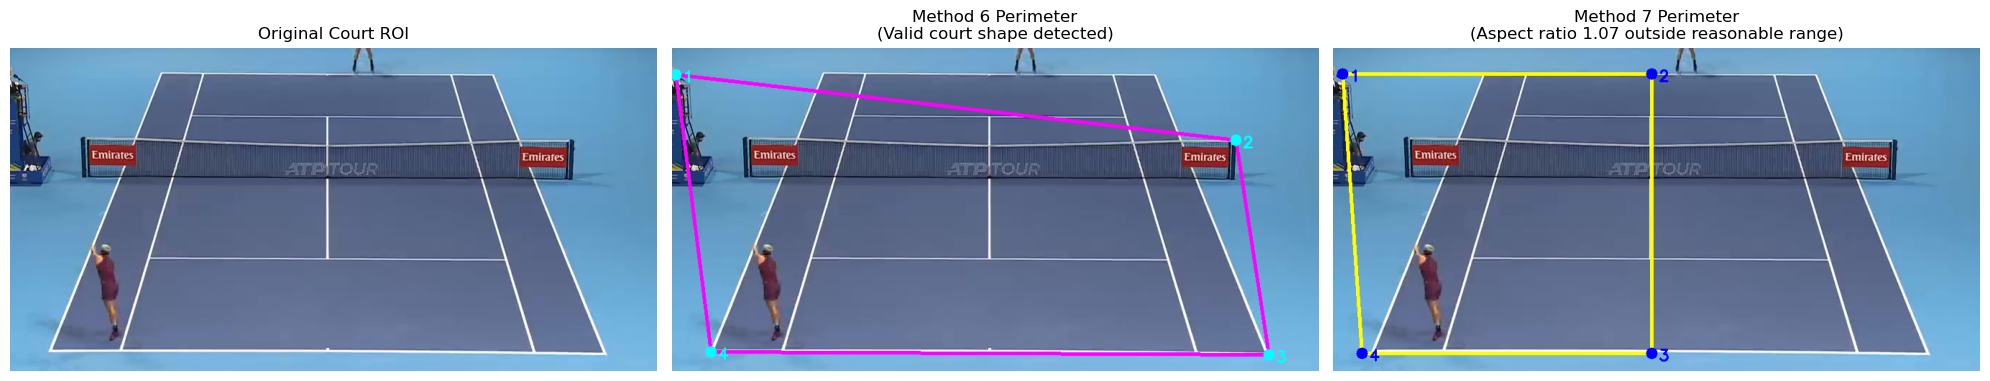


=== DETAILED CORNER COMPARISON ===
Method 6 (Simple Quadrant):
  top_left: (5, 38)
  top_right: (784, 129)
  bottom_left: (54, 423)
  bottom_right: (830, 427)

Method 7 (Line Intersections):
  top_left: (13, 37)
  top_right: (443, 37)
  bottom_left: (40, 425)
  bottom_right: (443, 425)

=== RECOMMENDATION ===
Best method: Method 6 (Simple Quadrant)
Perimeter points: 4 corners detected
Court perimeter successfully extracted!


In [25]:
def extract_court_perimeter(corners_dict):
    """Extract the outer court perimeter from detected corners"""
    
    # Filter out None values
    valid_corners = {k: v for k, v in corners_dict.items() if v is not None}
    
    if len(valid_corners) < 3:
        print("Not enough corners detected for perimeter extraction")
        return None
    
    # Order corners for perimeter (clockwise from top-left)
    corner_order = ['top_left', 'top_right', 'bottom_right', 'bottom_left']
    
    perimeter_points = []
    for corner_name in corner_order:
        if corner_name in valid_corners:
            perimeter_points.append(valid_corners[corner_name])
    
    return np.array(perimeter_points, dtype=np.int32)

def validate_court_shape(corners_dict):
    """Validate if detected corners form a reasonable tennis court shape"""
    
    valid_corners = {k: v for k, v in corners_dict.items() if v is not None}
    
    if len(valid_corners) < 4:
        return False, "Not all corners detected"
    
    # Extract corner coordinates
    tl = valid_corners.get('top_left')
    tr = valid_corners.get('top_right')
    bl = valid_corners.get('bottom_left')
    br = valid_corners.get('bottom_right')
    
    # Check if we have all corners
    if None in [tl, tr, bl, br]:
        return False, "Missing corners"
    
    # Check basic geometry constraints
    # Top-left should be top-left of others
    if not (tl[0] <= tr[0] and tl[1] <= bl[1]):
        return False, "Top-left corner position invalid"
    
    # Top-right should be top-right of others
    if not (tr[0] >= tl[0] and tr[1] <= br[1]):
        return False, "Top-right corner position invalid"
    
    # Calculate distances for aspect ratio check
    top_width = abs(tr[0] - tl[0])
    bottom_width = abs(br[0] - bl[0])
    left_height = abs(bl[1] - tl[1])
    right_height = abs(br[1] - tr[1])
    
    # Tennis court aspect ratio is approximately 2.34:1 (78ft x 36ft)
    # But due to perspective, we'll be more lenient
    avg_width = (top_width + bottom_width) / 2
    avg_height = (left_height + right_height) / 2
    
    if avg_height > 0:
        aspect_ratio = avg_width / avg_height
        if aspect_ratio < 1.5 or aspect_ratio > 4.0:
            return False, f"Aspect ratio {aspect_ratio:.2f} outside reasonable range"
    
    return True, "Valid court shape detected"

# Extract perimeter from both corner detection methods
perimeter_simple = extract_court_perimeter(corners)
perimeter_intersections = extract_court_perimeter(intersection_corners)

# Validate both methods
valid_simple, msg_simple = validate_court_shape(corners)
valid_intersections, msg_intersections = validate_court_shape(intersection_corners)

print("=== CORNER DETECTION VALIDATION ===")
print(f"Method 6 (Simple quadrant): {msg_simple}")
print(f"Method 7 (Line intersections): {msg_intersections}")

# Visualize both perimeters
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Original
axes[0].imshow(cv2.cvtColor(court_roi, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Court ROI')
axes[0].axis('off')

# Method 6 perimeter
court_perimeter_simple = court_roi.copy()
if perimeter_simple is not None and len(perimeter_simple) >= 3:
    cv2.polylines(court_perimeter_simple, [perimeter_simple], True, (255, 0, 255), 3)
    for i, point in enumerate(perimeter_simple):
        cv2.circle(court_perimeter_simple, tuple(point), 8, (255, 255, 0), -1)
        cv2.putText(court_perimeter_simple, str(i+1), tuple(point + 10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)

axes[1].imshow(cv2.cvtColor(court_perimeter_simple, cv2.COLOR_BGR2RGB))
axes[1].set_title(f'Method 6 Perimeter\n({msg_simple})')
axes[1].axis('off')

# Method 7 perimeter
court_perimeter_intersections = court_roi.copy()
if perimeter_intersections is not None and len(perimeter_intersections) >= 3:
    cv2.polylines(court_perimeter_intersections, [perimeter_intersections], True, (0, 255, 255), 3)
    for i, point in enumerate(perimeter_intersections):
        cv2.circle(court_perimeter_intersections, tuple(point), 8, (255, 0, 0), -1)
        cv2.putText(court_perimeter_intersections, str(i+1), tuple(point + 10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

axes[2].imshow(cv2.cvtColor(court_perimeter_intersections, cv2.COLOR_BGR2RGB))
axes[2].set_title(f'Method 7 Perimeter\n({msg_intersections})')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Print detailed corner information
print("\n=== DETAILED CORNER COMPARISON ===")
print("Method 6 (Simple Quadrant):")
for quad_name, corner in corners.items():
    print(f"  {quad_name}: {corner}")

print("\nMethod 7 (Line Intersections):")
for quad_name, corner in intersection_corners.items():
    print(f"  {quad_name}: {corner}")

# Choose the best method based on validation
if valid_intersections and not valid_simple:
    best_perimeter = perimeter_intersections
    best_method = "Method 7 (Line Intersections)"
elif valid_simple and not valid_intersections:
    best_perimeter = perimeter_simple
    best_method = "Method 6 (Simple Quadrant)"
elif valid_intersections and valid_simple:
    # Both valid, choose based on number of detected corners
    if len([c for c in intersection_corners.values() if c]) >= len([c for c in corners.values() if c]):
        best_perimeter = perimeter_intersections
        best_method = "Method 7 (Line Intersections)"
    else:
        best_perimeter = perimeter_simple
        best_method = "Method 6 (Simple Quadrant)"
else:
    best_perimeter = None
    best_method = "No valid method"

print(f"\n=== RECOMMENDATION ===")
print(f"Best method: {best_method}")
if best_perimeter is not None:
    print(f"Perimeter points: {len(best_perimeter)} corners detected")
    print("Court perimeter successfully extracted!")